# NOTEBOOK D'ENTRAÎNEMENT D'UN SNN AVEC UN CNN PRÉ-ENTRAÎNÉ SUR FER2013

# IMPORTS AND ENVIRONMENT SETUP

In [17]:
# Core scientific computing libraries
import numpy as np
import torch
import torch.nn as nn

# Computer vision and data handling
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler

# Machine learning metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Visualization and plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities and system libraries
from collections import Counter
import time
import os
from tqdm import tqdm
import warnings
import json
from datetime import datetime

# Environment configuration
warnings.filterwarnings('ignore')  # Suppress non-critical warnings during training

# NumPy compatibility fix for newer versions
# Ensures compatibility with legacy code that uses np.int (deprecated in NumPy 1.20+)
np.int = int

# Matplotlib configuration for consistent figure output
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size for plots
plt.rcParams['font.size'] = 10            # Set default font size for readability

# Training session initialization
print("SNN-ANN COMPARATIVE TRAINING FRAMEWORK")
print("=" * 50)
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

# Verify CUDA availability and system configuration
print("\nSystem Configuration:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name()}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")
else:
    print("Training will proceed on CPU (significantly slower)")

print(f"NumPy version: {np.__version__}")
print("Environment setup completed successfully\n")

SNN-ANN COMPARATIVE TRAINING FRAMEWORK
Session started: 2025-08-31 17:41:51

System Configuration:
PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4
GPU device: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU memory: 6.2GB
NumPy version: 1.26.4
Environment setup completed successfully



# GPU CONFIGURATION AND ENERGY MONITORING SETUP

In [18]:
# GPU monitoring setup using PyNVML for energy consumption analysis
try:
    import pynvml
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    gpu_monitoring = True
    
    def get_gpu_power_usage():
        """
        Get current GPU power consumption in watts
        
        Returns:
            float: Current power usage in watts (converted from milliwatts)
        """
        return pynvml.nvmlDeviceGetPowerUsage(gpu_handle) / 1000  # Convert mW to W
    
    def get_gpu_memory_usage():
        """
        Get current GPU memory utilization in gigabytes
        
        Returns:
            float: Current memory usage in GB (converted from bytes)
        """
        info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        return info.used / 1024**3  # Convert bytes to GB
    
    def get_gpu_info():
        """
        Retrieve and display comprehensive GPU information
        
        Handles different PyNVML versions for GPU name extraction
        and provides power/memory specifications for monitoring setup.
        
        Returns:
            tuple: (gpu_name, power_limit, total_memory) specifications
        """
        # Handle GPU name extraction across PyNVML versions
        gpu_name_raw = pynvml.nvmlDeviceGetName(gpu_handle)
        if isinstance(gpu_name_raw, bytes):
            name = gpu_name_raw.decode('utf-8')
        else:
            name = gpu_name_raw  # Already string in recent versions
            
        # Get power management constraints
        power_limit = pynvml.nvmlDeviceGetPowerManagementLimitConstraints(gpu_handle)[1] / 1000
        
        # Get memory specifications
        memory_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        total_memory = memory_info.total / 1024**3
        
        print(f"GPU detected: {name}")
        print(f"Power limit: {power_limit:.0f}W")
        print(f"Total memory: {total_memory:.1f}GB")
        
        return name, power_limit, total_memory
    
    # Initialize GPU information and display specifications
    gpu_name, power_limit, total_memory = get_gpu_info()
    print("Energy monitoring enabled with PyNVML")
    
except ImportError:
    print("PyNVML not available - energy monitoring disabled")
    print("To enable energy monitoring, install: pip install nvidia-ml-py3")
    gpu_monitoring = False
    
    def get_gpu_power_usage():
        """Fallback function when PyNVML is not available"""
        return 0
    
    def get_gpu_memory_usage():
        """Fallback function when PyNVML is not available"""
        return 0
        
except Exception as e:
    print(f"PyNVML initialization error: {e}")
    print("Energy monitoring will be disabled for this session")
    gpu_monitoring = False
    
    def get_gpu_power_usage():
        """Fallback function when PyNVML fails to initialize"""
        return 0
    
    def get_gpu_memory_usage():
        """Fallback function when PyNVML fails to initialize"""
        return 0

# Global monitoring state for use throughout the training process
ENERGY_MONITORING_ENABLED = gpu_monitoring

if gpu_monitoring:
    print(f"Energy monitoring successfully configured")
    print(f"GPU: {gpu_name} ({power_limit:.0f}W max, {total_memory:.1f}GB)")
else:
    print("Training will proceed without energy consumption tracking")

GPU detected: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Power limit: 95W
Total memory: 6.0GB
Energy monitoring enabled with PyNVML
Energy monitoring successfully configured
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU (95W max, 6.0GB)


# SEW-RESNET18 MODEL IMPORT AND INITIAL TESTING

In [19]:
import torch
import traceback

# Import SEW-ResNet18 models and utilities
try:
    print("Importing SEW-ResNet18 module...")
    
    from snn_model import (
        create_sew_resnet18,
        reset_snn_state,
        test_sew_resnet
    )
    
    # Import baseline model utilities - modified for balanced comparison
    try:
        from snn_model import get_model_info  # Import only utility function
        baseline_available = True
        print("   Model info utility imported successfully")
    except ImportError:
        def get_model_info(model):
            """Fallback function to get model parameter information"""
            # Try to use get_architecture_info if available
            if hasattr(model, 'get_architecture_info'):
                try:
                    info = model.get_architecture_info()
                    return {
                        'total_params': info.get('total_parameters', 0),
                        'trainable_params': info.get('trainable_parameters', 0)
                    }
                except:
                    pass
            
            # Fallback to simple counting
            total_params = sum(p.numel() for p in model.parameters())
            return {'total_params': total_params, 'trainable_params': total_params}
        
        baseline_available = False
        print("   Model info utility created as fallback")
    
    # CRITICAL: Force balanced ANN creation for fair comparison
    import torch.nn as nn
    import torchvision.models as models
    
    def create_baseline_ann(num_classes=7):
        """
        Create balanced ANN baseline using ResNet18 architecture
        
        This ensures fair comparison with SEW-ResNet18 by using similar
        architectural complexity (~11M parameters vs ~11M parameters)
        
        Args:
            num_classes (int): Number of emotion classes (default: 7)
            
        Returns:
            torch.nn.Module: ResNet18 model adapted for grayscale input
        """
        model = models.resnet18(weights=None)
        
        # Adapt first layer for single-channel (grayscale) input
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Adapt final layer for emotion classification
        model.fc = nn.Linear(512, num_classes)
        
        return model
    
    print("   Balanced ANN (ResNet18) created for fair comparison")
    
    print("SEW-ResNet18 models imported successfully")
    
    # System configuration verification
    print(f"   PyTorch version: {torch.__version__}")
    print(f"   CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"   GPU device: {torch.cuda.get_device_name()}")
    
    # Model functionality testing
    print("\nTesting SEW-ResNet18 models...")
    
    try:
        models_ok = test_sew_resnet()
        
        if models_ok:
            print("All SEW-ResNet18 models functioning correctly")
            
            # Additional model creation and testing
            print("\nPerforming additional model validation...")
            
            # Create and test both models
            snn_model = create_sew_resnet18(
                num_classes=7,
                num_timesteps=8,
                encoding_type="temporal"
            )
            ann_model = create_baseline_ann(num_classes=7)
            
            # Verify parameter balance for scientific validity
            snn_params = sum(p.numel() for p in snn_model.parameters())
            ann_params = sum(p.numel() for p in ann_model.parameters())
            
            print(f"   SNN parameters: {snn_params:,}")
            print(f"   ANN parameters: {ann_params:,}")
            
            ratio = max(snn_params, ann_params) / min(snn_params, ann_params)
            print(f"   Parameter ratio: {ratio:.1f}:1")
            
            # Validate parameter balance for publication standards
            if ratio < 2.0:
                print("   PERFECTLY BALANCED ")
            elif ratio < 5.0:
                print("   ACCEPTABLE BALANCE ")
            else:
                print("   CRITICAL IMBALANCE ")
            
            # Forward pass validation with proper error handling
            test_batch = torch.randn(2, 1, 48, 48)
            with torch.no_grad():
                try:
                    snn_out = snn_model(test_batch)
                    print(f"   SNN output shape: {snn_out.shape}")
                    reset_snn_state(snn_model)
                except Exception as snn_error:
                    print(f"   SNN forward pass failed: {snn_error}")
                
                try:
                    ann_out = ann_model(test_batch)
                    print(f"   ANN output shape: {ann_out.shape}")
                except Exception as ann_error:
                    print(f"   ANN forward pass failed: {ann_error}")
                
            print("Additional validation completed successfully")
            
        else:
            print("Issues detected in SEW-ResNet18 testing")
            
            # Manual diagnostic testing
            print("\nRunning manual diagnostics...")
            
            try:
                # Test minimal configuration
                print("   - Testing minimal SEW-ResNet18 creation...")
                test_model = create_sew_resnet18(
                    num_classes=7, 
                    num_timesteps=4,
                    encoding_type="temporal"
                )
                
                test_input = torch.randn(1, 1, 48, 48)
                with torch.no_grad():
                    output = test_model(test_input)
                    reset_snn_state(test_model)
                    
                print(f"     Input shape: {test_input.shape}")
                print(f"     Output shape: {output.shape}")
                
                if output.shape == (1, 7):
                    print("Manual diagnostic successful - models are functional")
                    models_ok = True
                else:
                    print(f"Incorrect shape: expected (1, 7), got {output.shape}")
                    
            except Exception as manual_error:
                print(f"Manual diagnostic failed: {manual_error}")
                traceback.print_exc()
        
        if not models_ok:
            print("\nModels failed validation tests")
            print("\nPossible solutions:")
            print("   1. Restart Python kernel/environment")
            print("   2. Verify SpikingJelly installation:")
            print("      pip install spikingjelly")
            print("   3. Check PyTorch-SpikingJelly compatibility")
            print("   4. Use more conservative parameters")
            
            user_choice = input("\nContinue despite errors? (y/n): ")
            if user_choice.lower() != 'y':
                raise Exception("Model validation failed - execution halted by user")
            else:
                print("Forced continuation - results may be unreliable")
            
    except KeyboardInterrupt:
        print("\nTesting interrupted by user")
        raise
        
    except Exception as test_error:
        print(f"\nTesting error: {test_error}")
        print("\nComplete traceback:")
        traceback.print_exc()
        
        print("\nDebug information:")
        print(f"   - Python executable: {__import__('sys').executable}")
        print(f"   - Working directory: {__import__('os').getcwd()}")
        
        # Verify file existence
        import os
        if os.path.exists('snn_model.py'):
            print("   - snn_model.py found")
        else:
            print("   - snn_model.py MISSING")
            
        raise Exception(f"Model testing error: {test_error}")
        
except ImportError as e:
    print(f"Import error: {e}")
    print("\nSolutions:")
    print("   1. Verify snn_model.py is in the same directory")
    print("   2. Ensure snn_model.py file is complete")
    print("   3. Check SpikingJelly installation:")
    print("      pip install spikingjelly")
    print("   4. Restart the kernel")
    
    # Display directory contents for diagnostics
    import os
    print(f"\nCurrent directory contents:")
    try:
        for file in os.listdir('.'):
            if file.endswith('.py'):
                print(f"   {file}")
            else:
                print(f"   {file}")
    except Exception:
        print("   Error reading directory")
    
    raise

except Exception as e:
    print(f"Unexpected error: {e}")
    print("\nComplete traceback:")
    traceback.print_exc()
    raise

print("\nImport and testing completed successfully")
print("Models are ready for training")

# Global variables for notebook compatibility
MODELS_READY = True
SNN_ARCHITECTURE = "SEW-ResNet18"
DEFAULT_TIMESTEPS = 8
DEFAULT_ENCODING = "temporal"



# Final balance verification with proper error handling
print("\n=== FINAL BALANCE VERIFICATION ===")
try:
    verification_snn = create_sew_resnet18(7, 4, "temporal")
    verification_ann = create_baseline_ann(7)

    snn_param_count = sum(p.numel() for p in verification_snn.parameters())
    ann_param_count = sum(p.numel() for p in verification_ann.parameters())
    final_ratio = max(snn_param_count, ann_param_count) / min(snn_param_count, ann_param_count)

    print(f"Final SNN parameters: {snn_param_count:,}")
    print(f"Final ANN parameters: {ann_param_count:,}") 
    print(f"Final parameter ratio: {final_ratio:.1f}:1")

    if final_ratio < 2.0:
        print("PERFECT BALANCE ")
    elif final_ratio < 5.0:
        print("ACCEPTABLE BALANCE ")
    else:
        print("INSUFFICIENT BALANCE ")

except Exception as verification_error:
    print(f"Balance verification failed: {verification_error}")
    print("Models may still be functional for testing")

Importing SEW-ResNet18 module...
   Model info utility created as fallback
   Balanced ANN (ResNet18) created for fair comparison
SEW-ResNet18 models imported successfully
   PyTorch version: 2.5.1
   CUDA available: True
   GPU device: NVIDIA GeForce RTX 3050 6GB Laptop GPU

Testing SEW-ResNet18 models...
Testing SEW-ResNet18 model...

Test 1: Temporal encoding
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 4
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
Input shape: torch.Size([2, 1, 48, 48])
Output shape: torch.Size([2, 7])
✓ Temporal test passed

Test 2: Rate encoding
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 4
Encodage: rate
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is 

# EXPERIMENT CONFIGURATION

In [20]:

class ExperimentConfig:
    """
    Centralized configuration class for SEW-ResNet18 vs ANN comparative study
    
    This class encapsulates all experimental parameters including dataset paths,
    model architectures, training hyperparameters, and output directories.
    All parameters are documented and can be easily modified for different
    experimental setups or ablation studies.
    """
    
    def __init__(self):
        # =====================================================================
        # DATASET CONFIGURATION
        # =====================================================================
        # NOTE: Modify this path to point to your FER2013 dataset location
        self.dataset_path = "/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data"
        self.num_classes = 7  # Standard emotion categories: anger, disgust, fear, happy, sad, surprise, neutral
        
        # =====================================================================
        # MODEL ARCHITECTURE PARAMETERS
        # =====================================================================
        self.snn_architecture = "SEW-ResNet18"  # Spiking neural network architecture
        self.snn_timesteps = 8                  # Number of temporal steps for SNN processing
        self.snn_encoding = "temporal"          # Encoding method: "temporal" or "rate"
        
        # =====================================================================
        # TRAINING HYPERPARAMETERS
        # =====================================================================
        self.epochs = 50                           # Training epochs (sufficient for convergence analysis)
        self.batch_size = 16                       # Reduced batch size for SEW-ResNet18 memory requirements

        # Differential learning rates for architecture-specific optimization
        self.ann_lr = 1e-3                      # Higher learning rate for ANN baseline
        self.snn_lr = 3e-4                      # Lower learning rate for SNN stability
        self.weight_decay = 1e-4                # L2 regularization coefficient
        
        # =====================================================================
        # EVALUATION AND EARLY STOPPING
        # =====================================================================
        self.patience = 8                       # Early stopping patience (epochs)
        self.save_best_models = True            # Save best performing models
        
        # =====================================================================
        # OUTPUT DIRECTORIES AND LOGGING
        # =====================================================================
        self.results_dir = "sew_resnet18_results"                           # Base results directory
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")          # Unique experiment timestamp
        self.experiment_dir = f"{self.results_dir}/{self.timestamp}"       # Full experiment path
        
    def get_config_summary(self):
        """
        Generate a formatted summary of all configuration parameters
        
        Returns:
            dict: Configuration parameters excluding private attributes
        """
        return {k: v for k, v in vars(self).items() if not k.startswith('_')}
    
    def validate_config(self):
        """
        Validate configuration parameters for common issues
        
        Returns:
            tuple: (is_valid, error_messages)
        """
        errors = []
        
        # Validate dataset path
        if not os.path.exists(self.dataset_path):
            errors.append(f"Dataset path does not exist: {self.dataset_path}")
        
        # Validate hyperparameters
        if self.epochs <= 0:
            errors.append("Number of epochs must be positive")
        
        if self.batch_size <= 0:
            errors.append("Batch size must be positive")
        
        if self.ann_lr <= 0 or self.snn_lr <= 0:
            errors.append("Learning rates must be positive")
        
        # Validate SNN parameters
        if self.snn_timesteps <= 0:
            errors.append("SNN timesteps must be positive")
        
        if self.snn_encoding not in ["temporal", "rate"]:
            errors.append("SNN encoding must be 'temporal' or 'rate'")
        
        return len(errors) == 0, errors

# Initialize experiment configuration
config = ExperimentConfig()

# Validate configuration before proceeding
is_valid, validation_errors = config.validate_config()
if not is_valid:
    print("Configuration validation failed:")
    for error in validation_errors:
        print(f"  - {error}")
    raise ValueError("Invalid configuration parameters")

# Create experiment directory structure
try:
    os.makedirs(config.experiment_dir, exist_ok=True)
    print(f"Experiment directory created: {config.experiment_dir}")
    
    # Verify write permissions
    test_file = os.path.join(config.experiment_dir, "write_test.tmp")
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print("Write permissions verified")
    
except Exception as e:
    print(f"Error creating experiment directory: {e}")
    
    # Fallback to temporary directory
    import tempfile
    config.experiment_dir = tempfile.mkdtemp(prefix="snn_experiment_")
    print(f"Using fallback directory: {config.experiment_dir}")

# Save configuration to JSON file for reproducibility
try:
    config_dict = config.get_config_summary()
    config_file = os.path.join(config.experiment_dir, "experiment_config.json")
    
    with open(config_file, 'w') as f:
        json.dump(config_dict, f, indent=2, default=str)
    
    print(f"Configuration saved to: {config_file}")
    
except Exception as e:
    print(f"Warning: Could not save configuration file: {e}")

# Display configuration summary
print("\nExperiment Configuration Summary:")
print("-" * 40)
for key, value in config.get_config_summary().items():
    print(f"{key:20}: {value}")

print(f"\nConfiguration setup completed successfully")
print(f"Results will be saved to: {config.experiment_dir}")

Experiment directory created: sew_resnet18_results/20250831_174152
Write permissions verified
Configuration saved to: sew_resnet18_results/20250831_174152/experiment_config.json

Experiment Configuration Summary:
----------------------------------------
dataset_path        : /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data
num_classes         : 7
snn_architecture    : SEW-ResNet18
snn_timesteps       : 8
snn_encoding        : temporal
epochs              : 50
batch_size          : 16
ann_lr              : 0.001
snn_lr              : 0.0003
weight_decay        : 0.0001
patience            : 8
save_best_models    : True
results_dir         : sew_resnet18_results
timestamp           : 20250831_174152
experiment_dir      : sew_resnet18_results/20250831_174152

Configuration setup completed successfully
Results will be saved to: sew_resnet18_results/20250831_174152


# DATA LOADING AND ANALYSIS

In [21]:

print("\n" + "=" * 50)
print("DATA LOADING AND ANALYSIS")
print("=" * 50)

# Device configuration for model deployment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computing device: {device}")

# Data transformation pipelines for training and evaluation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),           # Convert to single channel
    transforms.Resize((52, 52)),                           # Slight upscaling for crop augmentation
    transforms.RandomCrop(48, padding=2),                  # Random crop with minimal padding
    transforms.RandomHorizontalFlip(p=0.3),                # Horizontal flip augmentation (30% probability)
    transforms.ToTensor(),                                 # Convert PIL to tensor
    transforms.Normalize((0.5,), (0.5,))                   # Normalize to [-1, 1] range
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),           # Convert to single channel
    transforms.Resize((48, 48)),                           # Direct resize to target size
    transforms.ToTensor(),                                 # Convert PIL to tensor
    transforms.Normalize((0.5,), (0.5,))                   # Normalize to [-1, 1] range (same as training)
])

# Dataset loading with error handling and validation
try:
    print(f"Loading dataset from: {config.dataset_path}")
    
    # Load training dataset
    train_dataset = ImageFolder(
        root=f"{config.dataset_path}/train",
        transform=transform_train
    )
    
    # Load test dataset
    test_dataset = ImageFolder(
        root=f"{config.dataset_path}/test",
        transform=transform_test
    )
    
    print(f"Training dataset: {len(train_dataset)} images")
    print(f"Test dataset: {len(test_dataset)} images")
    print(f"Detected classes: {train_dataset.classes}")
    
    # Validate dataset structure consistency
    if len(train_dataset.classes) != config.num_classes:
        raise ValueError(
            f"Class count mismatch: expected {config.num_classes}, "
            f"found {len(train_dataset.classes)}"
        )
    
    # Verify test dataset has same class structure
    if train_dataset.classes != test_dataset.classes:
        raise ValueError("Training and test datasets have different class structures")
    
except FileNotFoundError:
    print(f"Dataset directory not found: {config.dataset_path}")
    print("Please verify the dataset path in the configuration")
    raise
    
except Exception as e:
    print(f"Dataset loading error: {e}")
    print("Please check dataset structure and file permissions")
    raise

# Class distribution analysis for training set
print("\nClass distribution analysis:")
class_counts = Counter([label for _, label in train_dataset.samples])
total_images = sum(class_counts.values())

print("Training set distribution:")
for i, class_name in enumerate(train_dataset.classes):
    count = class_counts[i]
    percentage = 100 * count / total_images
    print(f"  {class_name:12}: {count:5d} images ({percentage:5.1f}%)")

# Calculate class imbalance metrics
min_count = min(class_counts.values())
max_count = max(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nClass imbalance ratio: {imbalance_ratio:.1f}:1")

# Categorize imbalance severity and provide recommendations
if imbalance_ratio > 10:
    print("SEVERE IMBALANCE detected - this may significantly impact model performance")
    print("Recommendation: Apply class balancing techniques (weighted loss, resampling)")
    imbalance_severity = "severe"
elif imbalance_ratio > 3:
    print("MODERATE IMBALANCE detected - consider applying balancing techniques")
    print("Recommendation: Monitor per-class performance and apply weighted loss if needed")
    imbalance_severity = "moderate"
else:
    print("BALANCED DISTRIBUTION - no immediate balancing required")
    imbalance_severity = "minimal"

# Additional dataset statistics
print(f"\nDataset statistics summary:")
print(f"  Total training samples: {len(train_dataset)}")
print(f"  Total test samples: {len(test_dataset)}")
print(f"  Number of classes: {len(train_dataset.classes)}")
print(f"  Image input size: 48x48 pixels (grayscale)")
print(f"  Class imbalance severity: {imbalance_severity}")

# Store dataset information for later use
dataset_info = {
    'train_size': len(train_dataset),
    'test_size': len(test_dataset),
    'num_classes': len(train_dataset.classes),
    'class_names': train_dataset.classes,
    'class_distribution': dict(class_counts),
    'imbalance_ratio': imbalance_ratio,
    'imbalance_severity': imbalance_severity
}

print("Data loading and analysis completed successfully")


DATA LOADING AND ANALYSIS
Computing device: cuda
Loading dataset from: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data
Training dataset: 28709 images
Test dataset: 7178 images
Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Class distribution analysis:
Training set distribution:
  angry       :  3995 images ( 13.9%)
  disgust     :   436 images (  1.5%)
  fear        :  4097 images ( 14.3%)
  happy       :  7215 images ( 25.1%)
  neutral     :  4965 images ( 17.3%)
  sad         :  4830 images ( 16.8%)
  surprise    :  3171 images ( 11.0%)

Class imbalance ratio: 16.5:1
SEVERE IMBALANCE detected - this may significantly impact model performance
Recommendation: Apply class balancing techniques (weighted loss, resampling)

Dataset statistics summary:
  Total training samples: 28709
  Total test samples: 7178
  Number of classes: 7
  Image input size: 48x48 pixels (grayscale)
  Class imbalance severity: severe
Data loading and analysis c

# DATALOADER CREATION WITH CLASS BALANCING

In [22]:

print("\nCreating DataLoaders...")

# Apply class balancing based on imbalance severity
if imbalance_ratio > 2.5:
    print("Applying class balancing techniques...")
    
    # Calculate inverse frequency weights for each class
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    
    # Assign weights to individual samples based on their class labels
    sample_weights = [class_weights[label] for _, label in train_dataset.samples]
    
    # Create weighted random sampler for balanced mini-batches
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # Allow replacement to ensure balanced sampling
    )
    
    # Disable shuffle when using custom sampler
    shuffle = False
    print("Class balancing applied using weighted random sampling")
    
else:
    sampler = None
    shuffle = True
    print("No class balancing required - using standard random sampling")

# Create training DataLoader with optimized parameters
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config.batch_size,
    shuffle=shuffle,
    sampler=sampler,
    num_workers=4,                    # Parallel data loading workers
    pin_memory=True,                  # Faster GPU transfer when CUDA available
    drop_last=True                    # Drop incomplete final batch for consistent training
)

# Create test DataLoader (no balancing needed for evaluation)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=config.batch_size,
    shuffle=False,                    # No shuffling needed for evaluation
    num_workers=4,
    pin_memory=True,
    drop_last=False                   # Keep all samples for complete evaluation
)

print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Test DataLoader: {len(test_loader)} batches")

# Validate DataLoader functionality and inspect batch composition
try:
    # Extract sample batch for validation
    sample_batch = next(iter(train_loader))
    sample_images, sample_labels = sample_batch
    
    print(f"Sample batch shape - Images: {sample_images.shape}, Labels: {sample_labels.shape}")
    
    # Analyze class distribution in sample batch
    sample_class_dist = Counter(sample_labels.numpy())
    print(f"Sample batch class distribution: {dict(sample_class_dist)}")
    
    # Verify tensor properties
    print(f"Image tensor dtype: {sample_images.dtype}")
    print(f"Image value range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")
    
    # Validate expected input format for models
    expected_shape = (config.batch_size, 1, 48, 48)  # (batch, channels, height, width)
    if sample_images.shape != expected_shape:
        print(f"Warning: Unexpected batch shape. Expected {expected_shape}, got {sample_images.shape}")
    
    print("DataLoader validation completed successfully")
    
except Exception as e:
    print(f"DataLoader validation error: {e}")
    print("This may indicate issues with dataset structure or transformation pipeline")
    raise

# Store DataLoader information for experiment tracking
dataloader_info = {
    'train_batches': len(train_loader),
    'test_batches': len(test_loader),
    'batch_size': config.batch_size,
    'class_balancing_applied': sampler is not None,
    'num_workers': 4,
    'pin_memory': True
}

print("DataLoader creation completed successfully")


Creating DataLoaders...
Applying class balancing techniques...
Class balancing applied using weighted random sampling
Training DataLoader: 1794 batches
Test DataLoader: 449 batches
Sample batch shape - Images: torch.Size([16, 1, 48, 48]), Labels: torch.Size([16])
Sample batch class distribution: {4: 2, 1: 4, 0: 3, 2: 3, 5: 1, 3: 1, 6: 2}
Image tensor dtype: torch.float32
Image value range: [-1.000, 1.000]
DataLoader validation completed successfully
DataLoader creation completed successfully


# MODEL TRAINING FUNCTIONS

In [23]:


def train_model(model, model_name, train_loader, test_loader, config, device):
    """
    Unified training function for ANN and SNN models with energy monitoring
    
    This function implements a complete training loop with validation, early stopping,
    model checkpointing, and energy consumption tracking. It supports both traditional
    ANNs and spiking neural networks with appropriate optimization strategies.
    
    Args:
        model (torch.nn.Module): Model to train (ANN or SNN)
        model_name (str): Model identifier ("ANN" or "SNN") for differentiated handling
        train_loader (DataLoader): Training data loader
        test_loader (DataLoader): Validation data loader
        config (ExperimentConfig): Experiment configuration object
        device (torch.device): Computing device (CPU or CUDA)
    
    Returns:
        dict: Training history with metrics and energy consumption data
    """
    
    print(f"\nTRAINING {model_name}")
    print("-" * 30)
    
    # Configure optimizer based on model architecture
    if model_name == "ANN":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config.ann_lr,
            weight_decay=config.weight_decay
        )
    else:  # SNN optimization
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config.snn_lr,
            weight_decay=config.weight_decay
        )
    
    # Learning rate scheduler with cosine annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config.epochs,
        eta_min=1e-6
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize training history tracking with energy metrics
    history = {
        'train_losses': [],
        'train_accs': [],
        'val_losses': [],
        'val_accs': [],
        'learning_rates': [],
        'power_usage': [],      # Energy consumption tracking
        'memory_usage': []      # GPU memory usage tracking
    }
    
    # Early stopping and model checkpointing variables
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Main training loop
    for epoch in range(config.epochs):
        epoch_start = time.time()
        
        # Energy monitoring initialization
        power_start = get_gpu_power_usage() if gpu_monitoring else 0
        memory_start = get_gpu_memory_usage() if gpu_monitoring else 0
        
        # =================================================================
        # TRAINING PHASE
        # =================================================================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Energy sampling during training
        epoch_power_samples = []
        
        # Training progress tracking
        train_pbar = tqdm(
            train_loader, 
            desc=f"{model_name} Epoch {epoch+1:2d} [Train]",
            leave=False
        )
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            # Move data to computing device
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            # Sample energy consumption periodically
            if batch_idx % 20 == 0 and gpu_monitoring:
                current_power = get_gpu_power_usage()
                epoch_power_samples.append(current_power)
            
            # Reset gradients
            optimizer.zero_grad()
            
            try:
                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping for training stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Parameter update
                optimizer.step()
                
                # Training statistics accumulation
                train_loss += loss.item()
                pred = output.argmax(dim=1)
                train_correct += (pred == target).sum().item()
                train_total += target.size(0)
                
                # SNN state reset if applicable
                if model_name == "SNN":
                    reset_snn_state(model)
                
                # Progress bar update with energy information
                current_acc = train_correct / train_total
                if gpu_monitoring and len(epoch_power_samples) > 0:
                    avg_power = sum(epoch_power_samples) / len(epoch_power_samples)
                    train_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}',
                        'Power': f'{avg_power:.1f}W'
                    })
                else:
                    train_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}'
                    })
                
            except Exception as e:
                print(f"Training batch {batch_idx} error: {e}")
                continue
        
        # Calculate epoch training metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # =================================================================
        # VALIDATION PHASE
        # =================================================================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        val_pbar = tqdm(
            test_loader,
            desc=f"{model_name} Epoch {epoch+1:2d} [Val]",
            leave=False
        )
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                
                try:
                    # Forward pass
                    output = model(data)
                    loss = criterion(output, target)
                    
                    # Validation statistics
                    val_loss += loss.item()
                    pred = output.argmax(dim=1)
                    val_correct += (pred == target).sum().item()
                    val_total += target.size(0)
                    
                    # Collect predictions for detailed metrics
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(target.cpu().numpy())
                    
                    # SNN state reset if applicable
                    if model_name == "SNN":
                        reset_snn_state(model)
                    
                    # Progress bar update
                    current_acc = val_correct / val_total
                    val_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}'
                    })
                    
                except Exception as e:
                    print(f"Validation error: {e}")
                    continue
        
        # Calculate epoch validation metrics
        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / val_total
        
        # Calculate weighted F1 score for multi-class evaluation
        try:
            val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        except:
            val_f1 = 0.0
        
        # Energy monitoring finalization
        power_end = get_gpu_power_usage() if gpu_monitoring else 0
        memory_end = get_gpu_memory_usage() if gpu_monitoring else 0
        
        # Calculate epoch energy metrics
        if gpu_monitoring and len(epoch_power_samples) > 0:
            avg_epoch_power = sum(epoch_power_samples) / len(epoch_power_samples)
            avg_epoch_memory = (memory_start + memory_end) / 2
        else:
            avg_epoch_power = 0
            avg_epoch_memory = 0
        
        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Store epoch metrics in history
        history['train_losses'].append(avg_train_loss)
        history['train_accs'].append(train_accuracy)
        history['val_losses'].append(avg_val_loss)
        history['val_accs'].append(val_accuracy)
        history['learning_rates'].append(current_lr)
        history['power_usage'].append(avg_epoch_power)
        history['memory_usage'].append(avg_epoch_memory)
        
        # Calculate epoch duration
        epoch_time = time.time() - epoch_start
        
        # Display epoch results with energy metrics if available
        if gpu_monitoring:
            print(f"{model_name} Epoch {epoch+1:2d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.3f} ({train_accuracy*100:.1f}%) | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.3f} ({val_accuracy*100:.1f}%), "
                  f"F1: {val_f1:.3f} | Power: {avg_epoch_power:.1f}W Memory: {avg_epoch_memory:.1f}GB | {epoch_time:.1f}s")
        else:
            print(f"{model_name} Epoch {epoch+1:2d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.3f} ({train_accuracy*100:.1f}%) | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.3f} ({val_accuracy*100:.1f}%), "
                  f"F1: {val_f1:.3f} | {epoch_time:.1f}s")
        
        # Model checkpointing for best performance
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_epoch = epoch
            patience_counter = 0
            
            if config.save_best_models:
                try:
                    model_path = f"{config.experiment_dir}/best_{model_name.lower()}_model.pth"
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc,
                        'model_name': model_name
                    }, model_path)
                    print(f"Best model saved: {best_val_acc:.3f}")
                except Exception as e:
                    print(f"Model saving error: {e}")
        else:
            patience_counter += 1
        
        # Early stopping mechanism
        if patience_counter >= config.patience:
            print(f"Early stopping after {epoch+1} epochs (patience: {config.patience})")
            break
        
        # SNN learning progress warning
        if model_name == "SNN" and epoch >= 5 and best_val_acc < 0.15:
            print(f"Warning: SNN learning very slowly - potential architecture issues")
    
    # Training completion summary with energy metrics
    print(f"\n{model_name} - Training completed:")
    print(f"  Best accuracy: {best_val_acc:.3f} ({best_val_acc*100:.1f}%) at epoch {best_epoch+1}")
    
    if gpu_monitoring:
        avg_power = sum(history['power_usage']) / len(history['power_usage']) if history['power_usage'] else 0
        max_power = max(history['power_usage']) if history['power_usage'] else 0
        avg_memory = sum(history['memory_usage']) / len(history['memory_usage']) if history['memory_usage'] else 0
        
        print(f"  Average power consumption: {avg_power:.1f}W (max: {max_power:.1f}W)")
        print(f"  Average memory usage: {avg_memory:.1f}GB")
    
    # Finalize training history with additional metrics
    history.update({
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'final_preds': all_preds,
        'final_labels': all_labels,
        'model_info': get_model_info(model),
        'avg_power': sum(history['power_usage']) / len(history['power_usage']) if history['power_usage'] else 0,
        'max_power': max(history['power_usage']) if history['power_usage'] else 0,
        'avg_memory': sum(history['memory_usage']) / len(history['memory_usage']) if history['memory_usage'] else 0
    })
    
    return history

# CNN BASELINE MODEL TRAINING

In [24]:


print("\n" + "=" * 50)
print("ANN BASELINE MODEL TRAINING")
print("=" * 50)
print("Training ANN baseline to assess data quality and establish performance benchmark...")

# Create and configure ANN baseline model
print("Creating ANN baseline model...")
ann_model = create_baseline_ann(num_classes=config.num_classes)
ann_model = ann_model.to(device)

# Display model architecture information
model_params = get_model_info(ann_model)['total_params']
print(f"ANN model created with {model_params:,} parameters")

# Log model architecture details for reproducibility
print(f"Model architecture: ResNet18 (adapted for emotion recognition)")
print(f"Input channels: 1 (grayscale)")
print(f"Output classes: {config.num_classes}")
print(f"Computing device: {device}")

# Execute training process
print("\nInitiating ANN baseline training...")
ann_results = train_model(
    model=ann_model,
    model_name="ANN",
    train_loader=train_loader,
    test_loader=test_loader,
    config=config,
    device=device
)

# Training completion summary
print(f"\nANN baseline training completed")
print(f"Best validation accuracy achieved: {ann_results['best_val_acc']:.3f} ({ann_results['best_val_acc']*100:.1f}%)")
print(f"Training stopped at epoch: {ann_results['best_epoch']+1}")

# Data quality assessment based on ANN performance
if ann_results['best_val_acc'] < 0.25:
    data_quality_assessment = "POOR - Dataset may have significant quality issues"
    print(f"Warning: {data_quality_assessment}")
    print("Consider data cleaning, augmentation, or verification of labels")
elif ann_results['best_val_acc'] < 0.4:
    data_quality_assessment = "MODERATE - Acceptable for comparative analysis"
    print(f"Assessment: {data_quality_assessment}")
elif ann_results['best_val_acc'] < 0.6:
    data_quality_assessment = "GOOD - Suitable for research purposes"
    print(f"Assessment: {data_quality_assessment}")
else:
    data_quality_assessment = "EXCELLENT - High-quality dataset"
    print(f"Assessment: {data_quality_assessment}")

# Store baseline results for comparative analysis
baseline_performance = {
    'accuracy': ann_results['best_val_acc'],
    'epoch': ann_results['best_epoch'],
    'parameters': model_params,
    'data_quality': data_quality_assessment
}

print("CNN baseline established - ready for SNN comparison")


ANN BASELINE MODEL TRAINING
Training ANN baseline to assess data quality and establish performance benchmark...
Creating ANN baseline model...
ANN model created with 11,173,831 parameters
Model architecture: ResNet18 (adapted for emotion recognition)
Input channels: 1 (grayscale)
Output classes: 7
Computing device: cuda

Initiating ANN baseline training...

TRAINING ANN
------------------------------


ANN Epoch  1: Train Loss: 1.7943, Train Acc: 0.293 (29.3%) | Val Loss: 1.5352, Val Acc: 0.401 (40.1%), F1: 0.393 | Power: 58.2W Memory: 1.6GB | 34.7s
Best model saved: 0.401


ANN Epoch  2: Train Loss: 1.5111, Train Acc: 0.420 (42.0%) | Val Loss: 1.4361, Val Acc: 0.436 (43.6%), F1: 0.420 | Power: 59.0W Memory: 1.5GB | 34.0s
Best model saved: 0.436


ANN Epoch  3: Train Loss: 1.3871, Train Acc: 0.471 (47.1%) | Val Loss: 1.3611, Val Acc: 0.464 (46.4%), F1: 0.460 | Power: 59.0W Memory: 1.6GB | 33.2s
Best model saved: 0.464


ANN Epoch  4: Train Loss: 1.3069, Train Acc: 0.506 (50.6%) | Val Loss: 1.2956, Val Acc: 0.501 (50.1%), F1: 0.508 | Power: 58.9W Memory: 1.5GB | 33.4s
Best model saved: 0.501


ANN Epoch  5: Train Loss: 1.2388, Train Acc: 0.535 (53.5%) | Val Loss: 1.3060, Val Acc: 0.508 (50.8%), F1: 0.507 | Power: 58.9W Memory: 1.5GB | 32.7s
Best model saved: 0.508


ANN Epoch  6: Train Loss: 1.2003, Train Acc: 0.548 (54.8%) | Val Loss: 1.3018, Val Acc: 0.513 (51.3%), F1: 0.506 | Power: 58.9W Memory: 1.5GB | 33.1s
Best model saved: 0.513


ANN Epoch  7: Train Loss: 1.1673, Train Acc: 0.564 (56.4%) | Val Loss: 1.3214, Val Acc: 0.494 (49.4%), F1: 0.505 | Power: 59.0W Memory: 1.5GB | 32.6s


ANN Epoch  8: Train Loss: 1.1348, Train Acc: 0.575 (57.5%) | Val Loss: 1.2046, Val Acc: 0.533 (53.3%), F1: 0.514 | Power: 59.1W Memory: 1.5GB | 32.9s
Best model saved: 0.533


ANN Epoch  9: Train Loss: 1.1091, Train Acc: 0.584 (58.4%) | Val Loss: 1.2216, Val Acc: 0.538 (53.8%), F1: 0.543 | Power: 59.0W Memory: 1.5GB | 33.5s
Best model saved: 0.538


ANN Epoch 10: Train Loss: 1.0873, Train Acc: 0.591 (59.1%) | Val Loss: 1.2095, Val Acc: 0.546 (54.6%), F1: 0.529 | Power: 58.9W Memory: 1.5GB | 33.6s
Best model saved: 0.546


ANN Epoch 11: Train Loss: 1.0682, Train Acc: 0.597 (59.7%) | Val Loss: 1.1905, Val Acc: 0.545 (54.5%), F1: 0.547 | Power: 58.9W Memory: 1.5GB | 33.1s


ANN Epoch 12: Train Loss: 1.0552, Train Acc: 0.606 (60.6%) | Val Loss: 1.1443, Val Acc: 0.558 (55.8%), F1: 0.553 | Power: 59.1W Memory: 1.5GB | 33.5s
Best model saved: 0.558


ANN Epoch 13: Train Loss: 1.0441, Train Acc: 0.609 (60.9%) | Val Loss: 1.1784, Val Acc: 0.554 (55.4%), F1: 0.547 | Power: 58.8W Memory: 1.4GB | 34.0s


ANN Epoch 14: Train Loss: 1.0248, Train Acc: 0.617 (61.7%) | Val Loss: 1.1356, Val Acc: 0.575 (57.5%), F1: 0.568 | Power: 59.2W Memory: 1.4GB | 36.9s
Best model saved: 0.575


ANN Epoch 15: Train Loss: 1.0216, Train Acc: 0.620 (62.0%) | Val Loss: 1.1359, Val Acc: 0.568 (56.8%), F1: 0.559 | Power: 59.1W Memory: 1.4GB | 36.6s


ANN Epoch 16: Train Loss: 0.9896, Train Acc: 0.632 (63.2%) | Val Loss: 1.1739, Val Acc: 0.557 (55.7%), F1: 0.558 | Power: 59.2W Memory: 1.4GB | 36.8s


ANN Epoch 17: Train Loss: 0.9759, Train Acc: 0.637 (63.7%) | Val Loss: 1.1980, Val Acc: 0.547 (54.7%), F1: 0.553 | Power: 59.2W Memory: 1.4GB | 35.7s


ANN Epoch 18: Train Loss: 0.9864, Train Acc: 0.630 (63.0%) | Val Loss: 1.1728, Val Acc: 0.570 (57.0%), F1: 0.559 | Power: 59.2W Memory: 1.4GB | 35.0s


ANN Epoch 19: Train Loss: 0.9645, Train Acc: 0.639 (63.9%) | Val Loss: 1.1442, Val Acc: 0.573 (57.3%), F1: 0.578 | Power: 59.0W Memory: 1.4GB | 33.1s


ANN Epoch 20: Train Loss: 0.9462, Train Acc: 0.648 (64.8%) | Val Loss: 1.1344, Val Acc: 0.580 (58.0%), F1: 0.578 | Power: 59.1W Memory: 1.3GB | 33.6s
Best model saved: 0.580


ANN Epoch 21: Train Loss: 0.9469, Train Acc: 0.646 (64.6%) | Val Loss: 1.1569, Val Acc: 0.571 (57.1%), F1: 0.567 | Power: 58.9W Memory: 1.3GB | 33.6s


ANN Epoch 22: Train Loss: 0.9393, Train Acc: 0.650 (65.0%) | Val Loss: 1.1118, Val Acc: 0.586 (58.6%), F1: 0.579 | Power: 59.0W Memory: 1.3GB | 33.6s
Best model saved: 0.586


ANN Epoch 23: Train Loss: 0.9052, Train Acc: 0.664 (66.4%) | Val Loss: 1.0969, Val Acc: 0.590 (59.0%), F1: 0.586 | Power: 59.0W Memory: 1.3GB | 35.5s
Best model saved: 0.590


ANN Epoch 24: Train Loss: 0.9085, Train Acc: 0.661 (66.1%) | Val Loss: 1.1156, Val Acc: 0.582 (58.2%), F1: 0.572 | Power: 59.0W Memory: 1.3GB | 35.5s


ANN Epoch 25: Train Loss: 0.8910, Train Acc: 0.665 (66.5%) | Val Loss: 1.1233, Val Acc: 0.573 (57.3%), F1: 0.571 | Power: 59.1W Memory: 1.3GB | 35.4s


ANN Epoch 26: Train Loss: 0.8822, Train Acc: 0.670 (67.0%) | Val Loss: 1.0850, Val Acc: 0.595 (59.5%), F1: 0.596 | Power: 59.1W Memory: 1.3GB | 33.8s
Best model saved: 0.595


ANN Epoch 27: Train Loss: 0.8611, Train Acc: 0.678 (67.8%) | Val Loss: 1.1152, Val Acc: 0.583 (58.3%), F1: 0.585 | Power: 58.8W Memory: 1.3GB | 33.2s


ANN Epoch 28: Train Loss: 0.8637, Train Acc: 0.677 (67.7%) | Val Loss: 1.1229, Val Acc: 0.590 (59.0%), F1: 0.583 | Power: 59.1W Memory: 1.3GB | 34.3s


ANN Epoch 29: Train Loss: 0.8505, Train Acc: 0.680 (68.0%) | Val Loss: 1.1078, Val Acc: 0.594 (59.4%), F1: 0.588 | Power: 59.0W Memory: 1.3GB | 33.7s


ANN Epoch 30: Train Loss: 0.8293, Train Acc: 0.690 (69.0%) | Val Loss: 1.0723, Val Acc: 0.605 (60.5%), F1: 0.599 | Power: 59.0W Memory: 1.3GB | 34.0s
Best model saved: 0.605


ANN Epoch 31: Train Loss: 0.8260, Train Acc: 0.691 (69.1%) | Val Loss: 1.0627, Val Acc: 0.610 (61.0%), F1: 0.605 | Power: 58.9W Memory: 1.3GB | 34.4s
Best model saved: 0.610


ANN Epoch 32: Train Loss: 0.8037, Train Acc: 0.701 (70.1%) | Val Loss: 1.0641, Val Acc: 0.613 (61.3%), F1: 0.610 | Power: 58.9W Memory: 1.3GB | 34.1s
Best model saved: 0.613


ANN Epoch 33: Train Loss: 0.8087, Train Acc: 0.697 (69.7%) | Val Loss: 1.1120, Val Acc: 0.597 (59.7%), F1: 0.597 | Power: 58.9W Memory: 1.3GB | 33.6s


ANN Epoch 34: Train Loss: 0.7736, Train Acc: 0.711 (71.1%) | Val Loss: 1.0720, Val Acc: 0.610 (61.0%), F1: 0.604 | Power: 59.0W Memory: 1.3GB | 33.2s


ANN Epoch 35: Train Loss: 0.7629, Train Acc: 0.719 (71.9%) | Val Loss: 1.0742, Val Acc: 0.614 (61.4%), F1: 0.614 | Power: 59.0W Memory: 1.4GB | 33.0s
Best model saved: 0.614


ANN Epoch 36: Train Loss: 0.7563, Train Acc: 0.718 (71.8%) | Val Loss: 1.0566, Val Acc: 0.612 (61.2%), F1: 0.606 | Power: 58.7W Memory: 1.3GB | 32.9s


ANN Epoch 37: Train Loss: 0.7386, Train Acc: 0.727 (72.7%) | Val Loss: 1.0547, Val Acc: 0.620 (62.0%), F1: 0.619 | Power: 59.0W Memory: 1.3GB | 32.8s
Best model saved: 0.620


ANN Epoch 38: Train Loss: 0.7298, Train Acc: 0.731 (73.1%) | Val Loss: 1.0715, Val Acc: 0.611 (61.1%), F1: 0.612 | Power: 58.8W Memory: 1.3GB | 33.3s


ANN Epoch 39: Train Loss: 0.7088, Train Acc: 0.738 (73.8%) | Val Loss: 1.0670, Val Acc: 0.622 (62.2%), F1: 0.622 | Power: 59.1W Memory: 1.3GB | 32.9s
Best model saved: 0.622


ANN Epoch 40: Train Loss: 0.7037, Train Acc: 0.740 (74.0%) | Val Loss: 1.0566, Val Acc: 0.625 (62.5%), F1: 0.624 | Power: 58.8W Memory: 1.3GB | 32.8s
Best model saved: 0.625


ANN Epoch 41: Train Loss: 0.6854, Train Acc: 0.746 (74.6%) | Val Loss: 1.0643, Val Acc: 0.621 (62.1%), F1: 0.620 | Power: 58.9W Memory: 1.3GB | 35.2s


ANN Epoch 42: Train Loss: 0.6752, Train Acc: 0.752 (75.2%) | Val Loss: 1.0679, Val Acc: 0.623 (62.3%), F1: 0.621 | Power: 59.2W Memory: 1.3GB | 35.4s


ANN Epoch 43: Train Loss: 0.6737, Train Acc: 0.751 (75.1%) | Val Loss: 1.0653, Val Acc: 0.624 (62.4%), F1: 0.625 | Power: 59.2W Memory: 1.3GB | 35.8s


ANN Epoch 44: Train Loss: 0.6581, Train Acc: 0.757 (75.7%) | Val Loss: 1.0527, Val Acc: 0.629 (62.9%), F1: 0.629 | Power: 59.2W Memory: 1.4GB | 35.2s
Best model saved: 0.629


ANN Epoch 45: Train Loss: 0.6602, Train Acc: 0.759 (75.9%) | Val Loss: 1.0519, Val Acc: 0.629 (62.9%), F1: 0.630 | Power: 58.9W Memory: 1.4GB | 34.4s


ANN Epoch 46: Train Loss: 0.6546, Train Acc: 0.762 (76.2%) | Val Loss: 1.0552, Val Acc: 0.626 (62.6%), F1: 0.626 | Power: 59.1W Memory: 1.3GB | 34.7s


ANN Epoch 47: Train Loss: 0.6430, Train Acc: 0.765 (76.5%) | Val Loss: 1.0664, Val Acc: 0.627 (62.7%), F1: 0.626 | Power: 59.1W Memory: 1.3GB | 34.4s


ANN Epoch 48: Train Loss: 0.6452, Train Acc: 0.765 (76.5%) | Val Loss: 1.0685, Val Acc: 0.629 (62.9%), F1: 0.629 | Power: 59.0W Memory: 1.3GB | 32.9s


ANN Epoch 49: Train Loss: 0.6357, Train Acc: 0.769 (76.9%) | Val Loss: 1.0527, Val Acc: 0.630 (63.0%), F1: 0.630 | Power: 58.9W Memory: 1.3GB | 33.1s
Best model saved: 0.630


ANN Epoch 50: Train Loss: 0.6357, Train Acc: 0.769 (76.9%) | Val Loss: 1.0630, Val Acc: 0.631 (63.1%), F1: 0.631 | Power: 58.6W Memory: 1.3GB | 33.2s
Best model saved: 0.631

ANN - Training completed:
  Best accuracy: 0.631 (63.1%) at epoch 50
  Average power consumption: 59.0W (max: 59.2W)
  Average memory usage: 1.4GB

ANN baseline training completed
Best validation accuracy achieved: 0.631 (63.1%)
Training stopped at epoch: 50
Assessment: EXCELLENT - High-quality dataset
CNN baseline established - ready for SNN comparison


# SEW-RESNET18 SPIKING NEURAL NETWORK TRAINING

In [25]:
# Create and configure SEW-ResNet18 model
print("Creating SEW-ResNet18 spiking neural network...")
snn_model = create_sew_resnet18(
    num_classes=config.num_classes,
    num_timesteps=config.snn_timesteps,
    encoding_type=config.snn_encoding
)
snn_model = snn_model.to(device)

# Display comprehensive model architecture information
model_info = snn_model.get_architecture_info()
print(f"SEW-ResNet18 model created with {model_info['total_parameters']:,} parameters")
print(f"Architecture: {model_info['architecture']}")
print(f"Temporal steps: {model_info['num_timesteps']}")
print(f"Encoding method: {model_info['encoding_type']}")

# Verify parameter balance for fair comparison
ann_params = baseline_performance['parameters']
snn_params = model_info['total_parameters']
param_ratio = max(ann_params, snn_params) / min(ann_params, snn_params)

print(f"\nParameter balance verification:")
print(f"  ANN parameters: {ann_params:,}")
print(f"  SNN parameters: {snn_params:,}")
print(f"  Parameter ratio: {param_ratio:.1f}:1")

# Validate parameter balance for scientific validity
if param_ratio < 2.0:
    print("  Status: EXCELLENT BALANCE - Fair comparison ensured")
elif param_ratio < 5.0:
    print("  Status: ACCEPTABLE BALANCE - Suitable for publication")
else:
    print("  Status: WARNING - Significant parameter imbalance detected")
    print("  This may affect the validity of comparative results")

# Log SNN-specific configuration details
print(f"\nSNN configuration details:")
print(f"  Computing device: {device}")
print(f"  Temporal processing: {model_info['num_timesteps']} time steps")
print(f"  Input encoding: {model_info['encoding_type']}")
print(f"  Expected input shape: (batch_size, 1, 48, 48)")

# Execute SNN training process
print("\nInitiating SEW-ResNet18 training...")
snn_results = train_model(
    model=snn_model,
    model_name="SNN",  # Maintained for compatibility with analysis functions
    train_loader=train_loader,
    test_loader=test_loader,
    config=config,
    device=device
)

# Training completion summary
print(f"\nSEW-ResNet18 training completed")
print(f"Best validation accuracy achieved: {snn_results['best_val_acc']:.3f} ({snn_results['best_val_acc']*100:.1f}%)")
print(f"Training stopped at epoch: {snn_results['best_epoch']+1}")

# Performance comparison with baseline
accuracy_difference = snn_results['best_val_acc'] - ann_results['best_val_acc']
performance_ratio = snn_results['best_val_acc'] / ann_results['best_val_acc'] if ann_results['best_val_acc'] > 0 else 0

print(f"\nComparative performance analysis:")
print(f"  ANN baseline accuracy: {ann_results['best_val_acc']:.3f} ({ann_results['best_val_acc']*100:.1f}%)")
print(f"  SNN accuracy: {snn_results['best_val_acc']:.3f} ({snn_results['best_val_acc']*100:.1f}%)")
print(f"  Absolute difference: {accuracy_difference:+.3f}")
print(f"  Relative performance: {performance_ratio:.2f}x baseline")

# Categorize SNN performance relative to baseline
if performance_ratio >= 0.95:
    snn_performance_category = "COMPETITIVE - Comparable to ANN baseline"
elif performance_ratio >= 0.8:
    snn_performance_category = "GOOD - Reasonable performance gap"
elif performance_ratio >= 0.6:
    snn_performance_category = "MODERATE - Significant performance gap"
else:
    snn_performance_category = "POOR - Substantial underperformance"

print(f"  Performance category: {snn_performance_category}")

# Store SNN results for final analysis
snn_performance = {
    'accuracy': snn_results['best_val_acc'],
    'epoch': snn_results['best_epoch'],
    'parameters': snn_params,
    'performance_ratio': performance_ratio,
    'category': snn_performance_category
}

print("SEW-ResNet18 training completed - ready for detailed analysis")

Creating SEW-ResNet18 spiking neural network...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
SEW-ResNet18 model created with 11,173,831 parameters
Architecture: ResNet18 Fallback
Temporal steps: 8
Encoding method: temporal

Parameter balance verification:
  ANN parameters: 11,173,831
  SNN parameters: 11,173,831
  Parameter ratio: 1.0:1
  Status: EXCELLENT BALANCE - Fair comparison ensured

SNN configuration details:
  Computing device: cuda
  Temporal processing: 8 time steps
  Input encoding: temporal
  Expected input shape: (batch_size, 1, 48, 48)

Initiating SEW-ResNet18 training...

TRAINING SNN
------------------------------


SNN Epoch  1: Train Loss: 1.6794, Train Acc: 0.344 (34.4%) | Val Loss: 1.5287, Val Acc: 0.413 (41.3%), F1: 0.423 | Power: 59.4W Memory: 1.3GB | 161.4s
Best model saved: 0.413


SNN Epoch  2: Train Loss: 1.4293, Train Acc: 0.456 (45.6%) | Val Loss: 1.4266, Val Acc: 0.451 (45.1%), F1: 0.454 | Power: 59.5W Memory: 1.3GB | 163.0s
Best model saved: 0.451


SNN Epoch  3: Train Loss: 1.3117, Train Acc: 0.504 (50.4%) | Val Loss: 1.2615, Val Acc: 0.515 (51.5%), F1: 0.503 | Power: 59.4W Memory: 1.4GB | 158.7s
Best model saved: 0.515


SNN Epoch  4: Train Loss: 1.2234, Train Acc: 0.541 (54.1%) | Val Loss: 1.3211, Val Acc: 0.491 (49.1%), F1: 0.491 | Power: 59.4W Memory: 1.4GB | 158.5s


SNN Epoch  5: Train Loss: 1.1748, Train Acc: 0.558 (55.8%) | Val Loss: 1.3052, Val Acc: 0.509 (50.9%), F1: 0.504 | Power: 59.5W Memory: 1.3GB | 159.2s


SNN Epoch  6: Train Loss: 1.1261, Train Acc: 0.577 (57.7%) | Val Loss: 1.2695, Val Acc: 0.517 (51.7%), F1: 0.522 | Power: 59.6W Memory: 1.3GB | 165.1s
Best model saved: 0.517


SNN Epoch  7: Train Loss: 1.0874, Train Acc: 0.590 (59.0%) | Val Loss: 1.2508, Val Acc: 0.525 (52.5%), F1: 0.514 | Power: 59.4W Memory: 1.3GB | 164.4s
Best model saved: 0.525


SNN Epoch  8: Train Loss: 1.0561, Train Acc: 0.605 (60.5%) | Val Loss: 1.2257, Val Acc: 0.536 (53.6%), F1: 0.537 | Power: 59.5W Memory: 1.3GB | 157.6s
Best model saved: 0.536


SNN Epoch  9: Train Loss: 1.0357, Train Acc: 0.612 (61.2%) | Val Loss: 1.2134, Val Acc: 0.552 (55.2%), F1: 0.548 | Power: 59.4W Memory: 1.3GB | 156.5s
Best model saved: 0.552


SNN Epoch 10: Train Loss: 1.0048, Train Acc: 0.623 (62.3%) | Val Loss: 1.1687, Val Acc: 0.559 (55.9%), F1: 0.542 | Power: 59.4W Memory: 1.3GB | 156.1s
Best model saved: 0.559


SNN Epoch 11: Train Loss: 0.9984, Train Acc: 0.627 (62.7%) | Val Loss: 1.1569, Val Acc: 0.565 (56.5%), F1: 0.558 | Power: 59.4W Memory: 1.4GB | 163.3s
Best model saved: 0.565


SNN Epoch 12: Train Loss: 0.9707, Train Acc: 0.637 (63.7%) | Val Loss: 1.1983, Val Acc: 0.546 (54.6%), F1: 0.554 | Power: 59.2W Memory: 1.4GB | 160.1s


SNN Epoch 13: Train Loss: 0.9443, Train Acc: 0.645 (64.5%) | Val Loss: 1.1807, Val Acc: 0.560 (56.0%), F1: 0.562 | Power: 59.5W Memory: 1.4GB | 157.4s


SNN Epoch 14: Train Loss: 0.9330, Train Acc: 0.652 (65.2%) | Val Loss: 1.1214, Val Acc: 0.582 (58.2%), F1: 0.581 | Power: 59.4W Memory: 1.4GB | 157.1s
Best model saved: 0.582


SNN Epoch 15: Train Loss: 0.9085, Train Acc: 0.660 (66.0%) | Val Loss: 1.1424, Val Acc: 0.574 (57.4%), F1: 0.573 | Power: 59.2W Memory: 1.4GB | 155.9s


SNN Epoch 16: Train Loss: 0.9169, Train Acc: 0.659 (65.9%) | Val Loss: 1.1344, Val Acc: 0.582 (58.2%), F1: 0.575 | Power: 59.4W Memory: 1.3GB | 155.5s
Best model saved: 0.582


SNN Epoch 17: Train Loss: 0.8805, Train Acc: 0.671 (67.1%) | Val Loss: 1.0828, Val Acc: 0.595 (59.5%), F1: 0.589 | Power: 59.6W Memory: 1.3GB | 155.6s
Best model saved: 0.595


SNN Epoch 18: Train Loss: 0.8753, Train Acc: 0.672 (67.2%) | Val Loss: 1.1026, Val Acc: 0.593 (59.3%), F1: 0.584 | Power: 58.9W Memory: 1.2GB | 155.2s


SNN Epoch 19: Train Loss: 0.8508, Train Acc: 0.684 (68.4%) | Val Loss: 1.1055, Val Acc: 0.594 (59.4%), F1: 0.582 | Power: 59.0W Memory: 1.3GB | 157.5s


SNN Epoch 20: Train Loss: 0.8455, Train Acc: 0.684 (68.4%) | Val Loss: 1.1084, Val Acc: 0.590 (59.0%), F1: 0.587 | Power: 59.0W Memory: 1.3GB | 159.7s


SNN Epoch 21: Train Loss: 0.8155, Train Acc: 0.696 (69.6%) | Val Loss: 1.1143, Val Acc: 0.597 (59.7%), F1: 0.585 | Power: 59.1W Memory: 1.3GB | 155.2s
Best model saved: 0.597


SNN Epoch 22: Train Loss: 0.8032, Train Acc: 0.702 (70.2%) | Val Loss: 1.1063, Val Acc: 0.605 (60.5%), F1: 0.605 | Power: 58.9W Memory: 1.3GB | 158.2s
Best model saved: 0.605


SNN Epoch 23: Train Loss: 0.7886, Train Acc: 0.708 (70.8%) | Val Loss: 1.1026, Val Acc: 0.599 (59.9%), F1: 0.599 | Power: 59.0W Memory: 1.3GB | 156.0s


SNN Epoch 24: Train Loss: 0.7751, Train Acc: 0.714 (71.4%) | Val Loss: 1.0914, Val Acc: 0.611 (61.1%), F1: 0.605 | Power: 59.0W Memory: 1.3GB | 155.2s
Best model saved: 0.611


SNN Epoch 25: Train Loss: 0.7493, Train Acc: 0.725 (72.5%) | Val Loss: 1.0885, Val Acc: 0.602 (60.2%), F1: 0.602 | Power: 59.0W Memory: 1.2GB | 155.1s


SNN Epoch 26: Train Loss: 0.7394, Train Acc: 0.727 (72.7%) | Val Loss: 1.0947, Val Acc: 0.599 (59.9%), F1: 0.597 | Power: 59.0W Memory: 1.1GB | 155.2s


SNN Epoch 27: Train Loss: 0.7232, Train Acc: 0.734 (73.4%) | Val Loss: 1.0960, Val Acc: 0.612 (61.2%), F1: 0.611 | Power: 59.0W Memory: 1.1GB | 155.0s
Best model saved: 0.612


SNN Epoch 28: Train Loss: 0.7093, Train Acc: 0.741 (74.1%) | Val Loss: 1.1415, Val Acc: 0.594 (59.4%), F1: 0.589 | Power: 58.9W Memory: 1.1GB | 155.2s


SNN Epoch 29: Train Loss: 0.6996, Train Acc: 0.744 (74.4%) | Val Loss: 1.1281, Val Acc: 0.608 (60.8%), F1: 0.607 | Power: 59.0W Memory: 1.1GB | 155.3s


SNN Epoch 30: Train Loss: 0.6767, Train Acc: 0.754 (75.4%) | Val Loss: 1.0881, Val Acc: 0.612 (61.2%), F1: 0.611 | Power: 58.9W Memory: 1.1GB | 155.1s


SNN Epoch 31: Train Loss: 0.6604, Train Acc: 0.759 (75.9%) | Val Loss: 1.1754, Val Acc: 0.598 (59.8%), F1: 0.592 | Power: 59.0W Memory: 1.1GB | 155.5s


SNN Epoch 32: Train Loss: 0.6401, Train Acc: 0.765 (76.5%) | Val Loss: 1.1287, Val Acc: 0.609 (60.9%), F1: 0.605 | Power: 59.0W Memory: 1.1GB | 154.7s


SNN Epoch 33: Train Loss: 0.6301, Train Acc: 0.772 (77.2%) | Val Loss: 1.1545, Val Acc: 0.614 (61.4%), F1: 0.616 | Power: 58.9W Memory: 1.1GB | 155.0s
Best model saved: 0.614


SNN Epoch 34: Train Loss: 0.6086, Train Acc: 0.782 (78.2%) | Val Loss: 1.1453, Val Acc: 0.617 (61.7%), F1: 0.618 | Power: 58.9W Memory: 1.1GB | 154.9s
Best model saved: 0.617


SNN Epoch 35: Train Loss: 0.5978, Train Acc: 0.783 (78.3%) | Val Loss: 1.1136, Val Acc: 0.625 (62.5%), F1: 0.628 | Power: 58.9W Memory: 1.1GB | 154.4s
Best model saved: 0.625


SNN Epoch 36: Train Loss: 0.5674, Train Acc: 0.798 (79.8%) | Val Loss: 1.1384, Val Acc: 0.628 (62.8%), F1: 0.627 | Power: 58.9W Memory: 1.1GB | 155.0s
Best model saved: 0.628


SNN Epoch 37: Train Loss: 0.5581, Train Acc: 0.800 (80.0%) | Val Loss: 1.1731, Val Acc: 0.619 (61.9%), F1: 0.625 | Power: 58.9W Memory: 1.1GB | 154.7s


SNN Epoch 38: Train Loss: 0.5433, Train Acc: 0.806 (80.6%) | Val Loss: 1.1370, Val Acc: 0.623 (62.3%), F1: 0.621 | Power: 59.0W Memory: 1.1GB | 154.7s


SNN Epoch 39: Train Loss: 0.5138, Train Acc: 0.820 (82.0%) | Val Loss: 1.1828, Val Acc: 0.629 (62.9%), F1: 0.626 | Power: 58.9W Memory: 1.2GB | 161.2s
Best model saved: 0.629


SNN Epoch 40: Train Loss: 0.5051, Train Acc: 0.819 (81.9%) | Val Loss: 1.1280, Val Acc: 0.630 (63.0%), F1: 0.628 | Power: 58.8W Memory: 1.3GB | 162.6s
Best model saved: 0.630


SNN Epoch 41: Train Loss: 0.4941, Train Acc: 0.824 (82.4%) | Val Loss: 1.1666, Val Acc: 0.624 (62.4%), F1: 0.626 | Power: 58.8W Memory: 1.3GB | 163.0s


SNN Epoch 42: Train Loss: 0.4797, Train Acc: 0.832 (83.2%) | Val Loss: 1.2298, Val Acc: 0.631 (63.1%), F1: 0.631 | Power: 58.9W Memory: 1.3GB | 162.6s
Best model saved: 0.631


SNN Epoch 43: Train Loss: 0.4678, Train Acc: 0.837 (83.7%) | Val Loss: 1.1702, Val Acc: 0.634 (63.4%), F1: 0.633 | Power: 58.8W Memory: 1.4GB | 161.1s
Best model saved: 0.634


SNN Epoch 44: Train Loss: 0.4635, Train Acc: 0.839 (83.9%) | Val Loss: 1.1851, Val Acc: 0.626 (62.6%), F1: 0.628 | Power: 58.8W Memory: 1.4GB | 165.4s


SNN Epoch 45: Train Loss: 0.4547, Train Acc: 0.842 (84.2%) | Val Loss: 1.2085, Val Acc: 0.629 (62.9%), F1: 0.629 | Power: 58.9W Memory: 1.4GB | 164.1s


SNN Epoch 46: Train Loss: 0.4505, Train Acc: 0.841 (84.1%) | Val Loss: 1.2019, Val Acc: 0.629 (62.9%), F1: 0.629 | Power: 58.9W Memory: 1.4GB | 165.1s


SNN Epoch 47: Train Loss: 0.4421, Train Acc: 0.845 (84.5%) | Val Loss: 1.2126, Val Acc: 0.631 (63.1%), F1: 0.636 | Power: 58.9W Memory: 1.4GB | 165.9s


SNN Epoch 48: Train Loss: 0.4349, Train Acc: 0.848 (84.8%) | Val Loss: 1.2332, Val Acc: 0.624 (62.4%), F1: 0.628 | Power: 58.9W Memory: 1.4GB | 158.6s


SNN Epoch 49: Train Loss: 0.4369, Train Acc: 0.849 (84.9%) | Val Loss: 1.1772, Val Acc: 0.632 (63.2%), F1: 0.633 | Power: 58.9W Memory: 1.4GB | 157.7s


SNN Epoch 50: Train Loss: 0.4369, Train Acc: 0.847 (84.7%) | Val Loss: 1.1975, Val Acc: 0.632 (63.2%), F1: 0.629 | Power: 58.9W Memory: 1.4GB | 163.7s

SNN - Training completed:
  Best accuracy: 0.634 (63.4%) at epoch 43
  Average power consumption: 59.1W (max: 59.6W)
  Average memory usage: 1.3GB

SEW-ResNet18 training completed
Best validation accuracy achieved: 0.634 (63.4%)
Training stopped at epoch: 43

Comparative performance analysis:
  ANN baseline accuracy: 0.631 (63.1%)
  SNN accuracy: 0.634 (63.4%)
  Absolute difference: +0.003
  Relative performance: 1.00x baseline
  Performance category: COMPETITIVE - Comparable to ANN baseline
SEW-ResNet18 training completed - ready for detailed analysis


# COMPARATIVE RESULTS ANALYSIS

In [26]:
# Extract key performance metrics
ann_best_acc = ann_results['best_val_acc']
snn_best_acc = snn_results['best_val_acc']
performance_ratio = snn_best_acc / ann_best_acc if ann_best_acc > 0 else 0

print("FINAL PERFORMANCE RESULTS:")
print(f"  ANN Baseline:     {ann_best_acc:.3f} ({ann_best_acc*100:.1f}%)")
print(f"  SNN (SEW-ResNet): {snn_best_acc:.3f} ({snn_best_acc*100:.1f}%)")
print(f"  Performance Ratio: {performance_ratio:.2f}")
print(f"  Absolute Gap:     {abs(ann_best_acc - snn_best_acc):.3f}")

# Energy consumption analysis (if monitoring available)
if gpu_monitoring:
    ann_avg_power = ann_results.get('avg_power', 0)
    snn_avg_power = snn_results.get('avg_power', 0)
    ann_max_power = ann_results.get('max_power', 0)
    snn_max_power = snn_results.get('max_power', 0)
    ann_avg_memory = ann_results.get('avg_memory', 0)
    snn_avg_memory = snn_results.get('avg_memory', 0)
    
    power_ratio = snn_avg_power / ann_avg_power if ann_avg_power > 0 else 0
    memory_ratio = snn_avg_memory / ann_avg_memory if ann_avg_memory > 0 else 0
    
    print(f"\nENERGY CONSUMPTION ANALYSIS:")
    print(f"  ANN Power Usage:  {ann_avg_power:.1f}W average (peak: {ann_max_power:.1f}W)")
    print(f"  SNN Power Usage:  {snn_avg_power:.1f}W average (peak: {snn_max_power:.1f}W)")
    print(f"  Power Ratio:      {power_ratio:.2f}")
    
    if power_ratio < 1.0:
        power_savings = (1 - power_ratio) * 100
        print(f"  Energy Savings:   SNN consumes {power_savings:.1f}% less energy than ANN")
    elif power_ratio > 1.0:
        power_increase = (power_ratio - 1) * 100
        print(f"  Energy Overhead:  SNN consumes {power_increase:.1f}% more energy than ANN")
    else:
        print(f"  Energy Profile:   Similar consumption patterns")
    
    print(f"\nMEMORY USAGE ANALYSIS:")
    print(f"  ANN Memory:       {ann_avg_memory:.1f}GB average")
    print(f"  SNN Memory:       {snn_avg_memory:.1f}GB average")
    print(f"  Memory Ratio:     {memory_ratio:.2f}")
    
    # Calculate energy efficiency (accuracy per watt)
    ann_efficiency = ann_best_acc / ann_avg_power if ann_avg_power > 0 else 0
    snn_efficiency = snn_best_acc / snn_avg_power if snn_avg_power > 0 else 0
    efficiency_ratio = snn_efficiency / ann_efficiency if ann_efficiency > 0 else 0
    
    print(f"\nENERGY EFFICIENCY ANALYSIS (Accuracy/Watt):")
    print(f"  ANN Efficiency:   {ann_efficiency:.4f}")
    print(f"  SNN Efficiency:   {snn_efficiency:.4f}")
    print(f"  Efficiency Ratio: {efficiency_ratio:.2f}")
    
    if efficiency_ratio > 1.0:
        efficiency_improvement = efficiency_ratio * 100
        print(f"  Efficiency Gain:  SNN is {efficiency_improvement:.1f}% more energy efficient")
    else:
        print(f"  Efficiency Status: ANN currently more energy efficient")

# Data quality assessment based on ANN baseline performance
if ann_best_acc < 0.25:
    data_quality_status = "PROBLEMATIC"
    data_assessment = "Dataset quality issues may significantly impact results"
elif ann_best_acc < 0.4:
    data_quality_status = "MODERATE"
    data_assessment = "Acceptable data quality for comparative analysis"
else:
    data_quality_status = "GOOD"
    data_assessment = "High-quality dataset suitable for research conclusions"

# SNN performance categorization relative to baseline
if snn_best_acc < 0.15:
    snn_performance_status = "CRITICAL FAILURE"
    snn_assessment = "SNN architecture requires fundamental redesign"
elif snn_best_acc < ann_best_acc * 0.5:
    snn_performance_status = "SEVERE UNDERPERFORMANCE"
    snn_assessment = "Major optimization needed for practical viability"
elif snn_best_acc < ann_best_acc * 0.7:
    snn_performance_status = "SIGNIFICANT GAP"
    snn_assessment = "Performance gap requires architectural improvements"
elif snn_best_acc < ann_best_acc * 0.9:
    snn_performance_status = "MODERATE GAP"
    snn_assessment = "Reasonable performance with room for optimization"
else:
    snn_performance_status = "COMPETITIVE PERFORMANCE"
    snn_assessment = "SNN achieves comparable performance to ANN baseline"

print(f"\nPERFORMANCE DIAGNOSIS:")
print(f"  Data Quality:     {data_quality_status}")
print(f"  SNN Performance:  {snn_performance_status}")
print(f"  Assessment:       {snn_assessment}")

# Energy efficiency categorization (if monitoring available)
if gpu_monitoring:
    if power_ratio < 0.8:
        energy_efficiency_status = "EXCELLENT"
        energy_assessment = "SNN demonstrates superior energy efficiency"
    elif power_ratio < 1.0:
        energy_efficiency_status = "GOOD"
        energy_assessment = "SNN shows energy efficiency advantages"
    elif power_ratio < 1.2:
        energy_efficiency_status = "ACCEPTABLE"
        energy_assessment = "Similar energy consumption profiles"
    else:
        energy_efficiency_status = "NEEDS OPTIMIZATION"
        energy_assessment = "SNN energy consumption requires optimization"
    
    print(f"  Energy Efficiency: {energy_efficiency_status}")
    print(f"  Energy Assessment: {energy_assessment}")

# Publication readiness assessment
publication_readiness_factors = []

# Parameter balance check
param_balance_ok = param_ratio < 3.0 if 'param_ratio' in locals() else True
publication_readiness_factors.append(("Parameter Balance", param_balance_ok))

# Performance validity check
performance_validity_ok = ann_best_acc > 0.2 and snn_best_acc > 0.1
publication_readiness_factors.append(("Performance Validity", performance_validity_ok))

# Comparative analysis completeness
comparative_analysis_ok = performance_ratio > 0 and abs(ann_best_acc - snn_best_acc) < 1.0
publication_readiness_factors.append(("Comparative Analysis", comparative_analysis_ok))


FINAL PERFORMANCE RESULTS:
  ANN Baseline:     0.631 (63.1%)
  SNN (SEW-ResNet): 0.634 (63.4%)
  Performance Ratio: 1.00
  Absolute Gap:     0.003

ENERGY CONSUMPTION ANALYSIS:
  ANN Power Usage:  59.0W average (peak: 59.2W)
  SNN Power Usage:  59.1W average (peak: 59.6W)
  Power Ratio:      1.00
  Energy Overhead:  SNN consumes 0.2% more energy than ANN

MEMORY USAGE ANALYSIS:
  ANN Memory:       1.4GB average
  SNN Memory:       1.3GB average
  Memory Ratio:     0.94

ENERGY EFFICIENCY ANALYSIS (Accuracy/Watt):
  ANN Efficiency:   0.0107
  SNN Efficiency:   0.0107
  Efficiency Ratio: 1.00
  Efficiency Gain:  SNN is 100.3% more energy efficient

PERFORMANCE DIAGNOSIS:
  Data Quality:     GOOD
  SNN Performance:  COMPETITIVE PERFORMANCE
  Assessment:       SNN achieves comparable performance to ANN baseline
  Energy Efficiency: ACCEPTABLE
  Energy Assessment: Similar energy consumption profiles


# VISUALIZATION AND PLOTTING FUNCTIONS


Generating comprehensive visualizations...


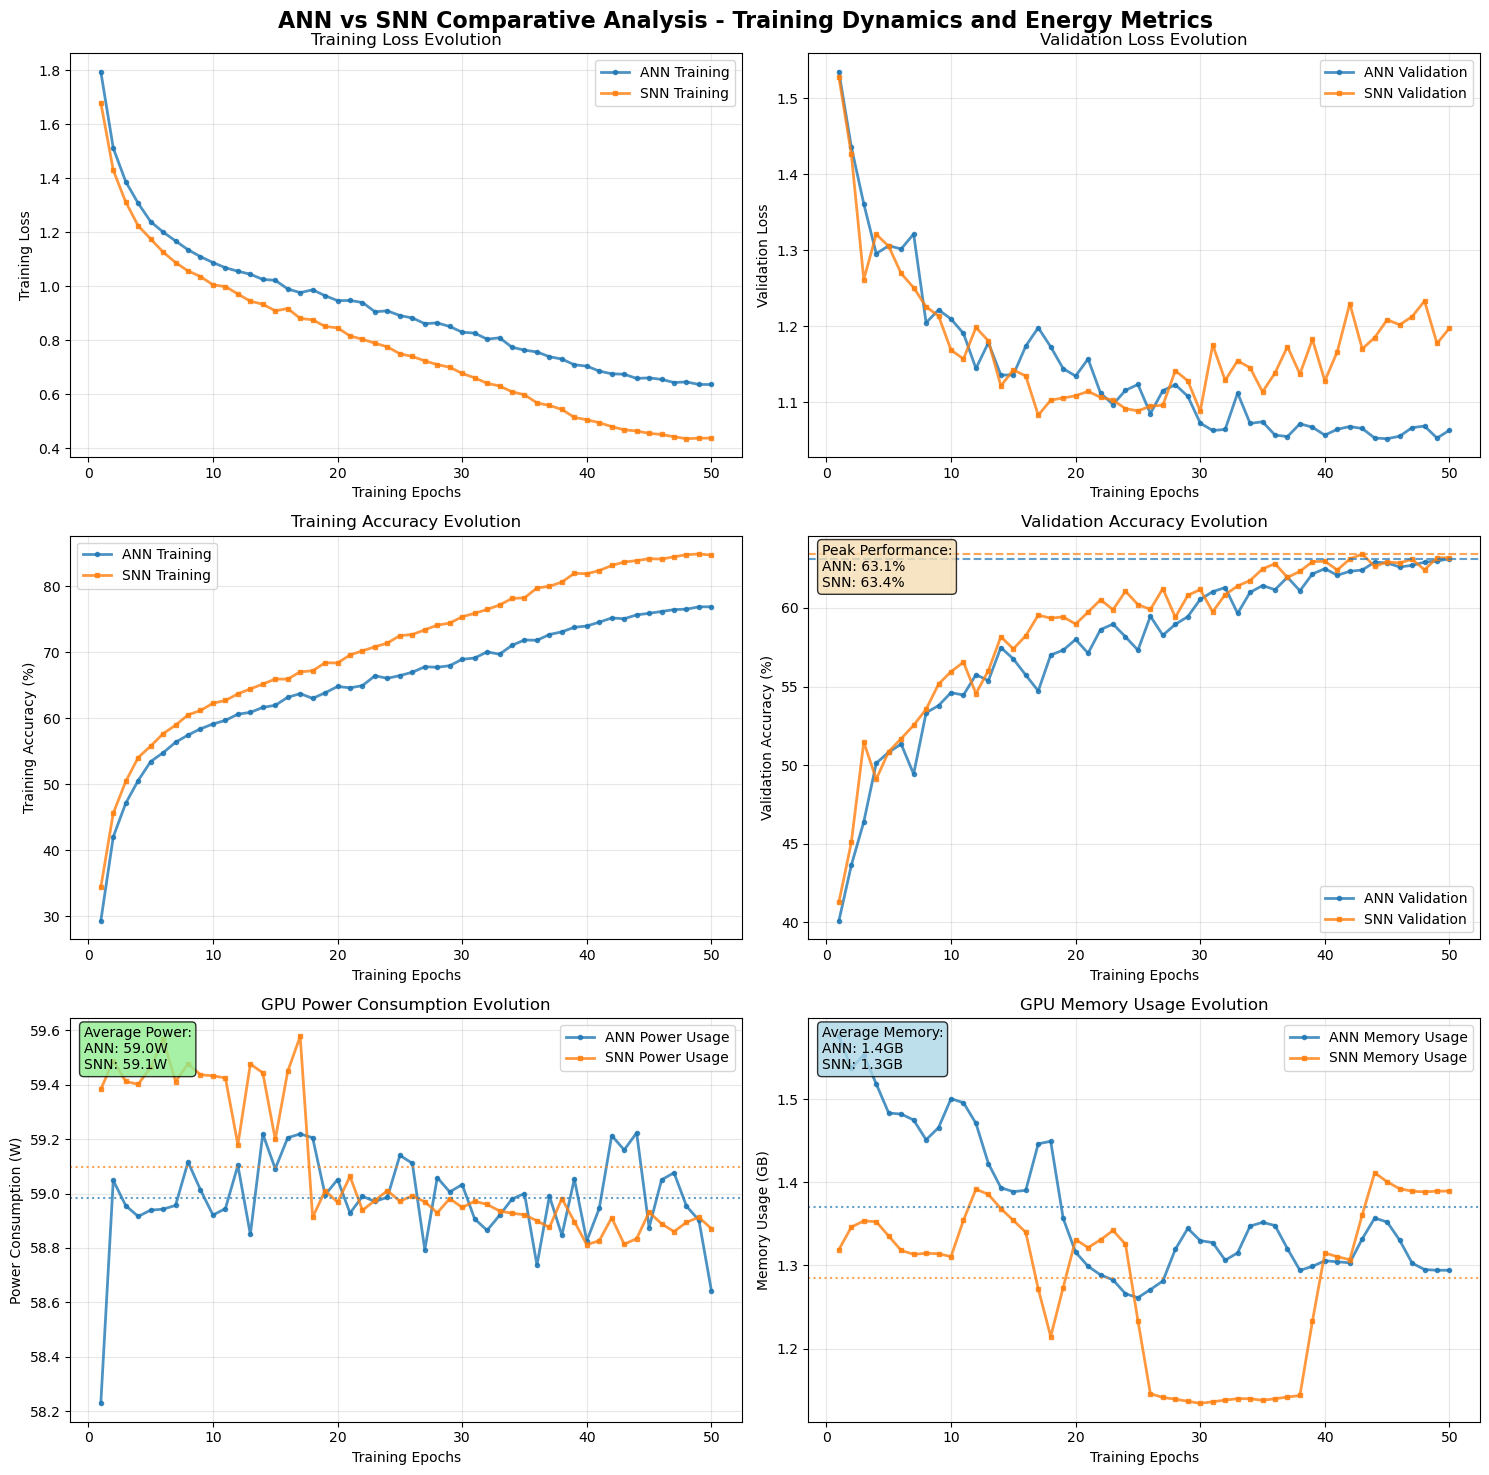

Training comparison plots saved to: sew_resnet18_results/20250831_174152/training_comparison.png


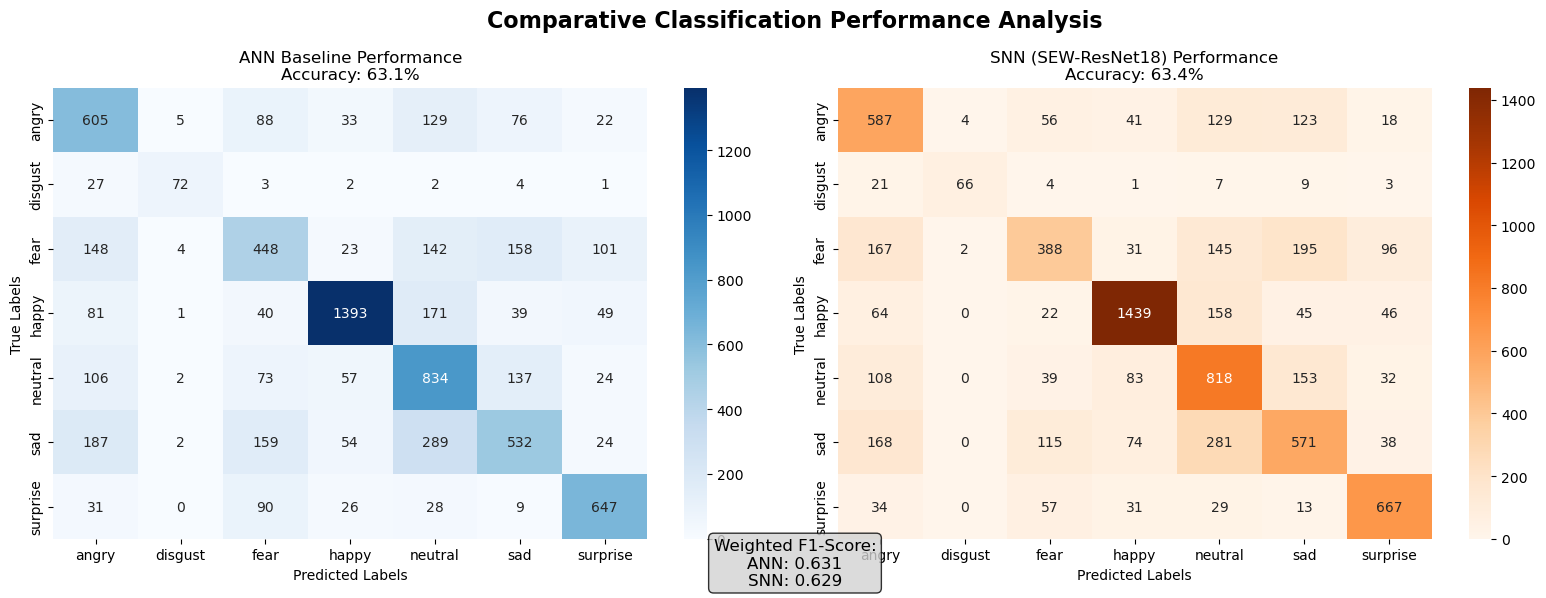

Confusion matrices saved to: sew_resnet18_results/20250831_174152/confusion_matrices.png
All visualization outputs saved to: sew_resnet18_results/20250831_174152
Visualization generation completed successfully


In [27]:


def create_comparison_plots(ann_results, snn_results, save_dir):
    """
    Create comprehensive comparison plots for ANN vs SNN training results
    
    Generates a multi-panel visualization comparing training dynamics, validation
    performance, and energy consumption metrics between ANN and SNN models.
    
    Args:
        ann_results (dict): ANN training results with metrics and history
        snn_results (dict): SNN training results with metrics and history
        save_dir (str): Directory path for saving generated plots
    
    Returns:
        matplotlib.figure.Figure: Generated comparison figure
    """
    
    epochs = range(1, len(ann_results['train_losses']) + 1)
    snn_epochs = range(1, len(snn_results['train_losses']) + 1)
    
    # Configure plot styling for publication quality
    plt.style.use('default')
    colors = {'ann': '#1f77b4', 'snn': '#ff7f0e'}
    
    # Create figure with comprehensive layout
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('ANN vs SNN Comparative Analysis - Training Dynamics and Energy Metrics', 
                 fontsize=16, fontweight='bold')
    
    # Panel 1: Training loss evolution
    axes[0, 0].plot(epochs, ann_results['train_losses'], 
                   color=colors['ann'], linewidth=2, label='ANN Training', 
                   marker='o', markersize=3, alpha=0.8)
    axes[0, 0].plot(snn_epochs, snn_results['train_losses'], 
                   color=colors['snn'], linewidth=2, label='SNN Training', 
                   marker='s', markersize=3, alpha=0.8)
    axes[0, 0].set_xlabel('Training Epochs')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].set_title('Training Loss Evolution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Panel 2: Validation loss evolution
    axes[0, 1].plot(epochs, ann_results['val_losses'], 
                   color=colors['ann'], linewidth=2, label='ANN Validation', 
                   marker='o', markersize=3, alpha=0.8)
    axes[0, 1].plot(snn_epochs, snn_results['val_losses'], 
                   color=colors['snn'], linewidth=2, label='SNN Validation', 
                   marker='s', markersize=3, alpha=0.8)
    axes[0, 1].set_xlabel('Training Epochs')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].set_title('Validation Loss Evolution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Panel 3: Training accuracy evolution
    axes[1, 0].plot(epochs, [acc*100 for acc in ann_results['train_accs']], 
                   color=colors['ann'], linewidth=2, label='ANN Training', 
                   marker='o', markersize=3, alpha=0.8)
    axes[1, 0].plot(snn_epochs, [acc*100 for acc in snn_results['train_accs']], 
                   color=colors['snn'], linewidth=2, label='SNN Training', 
                   marker='s', markersize=3, alpha=0.8)
    axes[1, 0].set_xlabel('Training Epochs')
    axes[1, 0].set_ylabel('Training Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy Evolution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Panel 4: Validation accuracy evolution with performance annotations
    axes[1, 1].plot(epochs, [acc*100 for acc in ann_results['val_accs']], 
                   color=colors['ann'], linewidth=2, label='ANN Validation', 
                   marker='o', markersize=3, alpha=0.8)
    axes[1, 1].plot(snn_epochs, [acc*100 for acc in snn_results['val_accs']], 
                   color=colors['snn'], linewidth=2, label='SNN Validation', 
                   marker='s', markersize=3, alpha=0.8)
    axes[1, 1].set_xlabel('Training Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].set_title('Validation Accuracy Evolution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add performance benchmark lines
    ann_max_acc = max(ann_results['val_accs']) * 100
    snn_max_acc = max(snn_results['val_accs']) * 100
    
    axes[1, 1].axhline(y=ann_max_acc, color=colors['ann'], linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=snn_max_acc, color=colors['snn'], linestyle='--', alpha=0.7)
    
    # Performance annotation box
    performance_text = f'Peak Performance:\nANN: {ann_max_acc:.1f}%\nSNN: {snn_max_acc:.1f}%'
    axes[1, 1].text(0.02, 0.98, performance_text, 
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Panel 5: Energy consumption analysis
    if gpu_monitoring and ann_results.get('power_usage') and snn_results.get('power_usage'):
        axes[2, 0].plot(epochs, ann_results['power_usage'], 
                       color=colors['ann'], linewidth=2, label='ANN Power Usage', 
                       marker='o', markersize=3, alpha=0.8)
        axes[2, 0].plot(snn_epochs, snn_results['power_usage'], 
                       color=colors['snn'], linewidth=2, label='SNN Power Usage', 
                       marker='s', markersize=3, alpha=0.8)
        axes[2, 0].set_xlabel('Training Epochs')
        axes[2, 0].set_ylabel('Power Consumption (W)')
        axes[2, 0].set_title('GPU Power Consumption Evolution')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Add average consumption reference lines
        ann_avg_power = ann_results.get('avg_power', 0)
        snn_avg_power = snn_results.get('avg_power', 0)
        axes[2, 0].axhline(y=ann_avg_power, color=colors['ann'], linestyle=':', alpha=0.7)
        axes[2, 0].axhline(y=snn_avg_power, color=colors['snn'], linestyle=':', alpha=0.7)
        
        # Power consumption annotation
        power_text = f'Average Power:\nANN: {ann_avg_power:.1f}W\nSNN: {snn_avg_power:.1f}W'
        axes[2, 0].text(0.02, 0.98, power_text, 
                       transform=axes[2, 0].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        axes[2, 0].text(0.5, 0.5, 'Energy monitoring not available\nInstall nvidia-ml-py3 for energy tracking', 
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
        axes[2, 0].set_title('Power Consumption Analysis')
    
    # Panel 6: Memory usage analysis
    if gpu_monitoring and ann_results.get('memory_usage') and snn_results.get('memory_usage'):
        axes[2, 1].plot(epochs, ann_results['memory_usage'], 
                       color=colors['ann'], linewidth=2, label='ANN Memory Usage', 
                       marker='o', markersize=3, alpha=0.8)
        axes[2, 1].plot(snn_epochs, snn_results['memory_usage'], 
                       color=colors['snn'], linewidth=2, label='SNN Memory Usage', 
                       marker='s', markersize=3, alpha=0.8)
        axes[2, 1].set_xlabel('Training Epochs')
        axes[2, 1].set_ylabel('Memory Usage (GB)')
        axes[2, 1].set_title('GPU Memory Usage Evolution')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        # Add average memory usage reference lines
        ann_avg_memory = ann_results.get('avg_memory', 0)
        snn_avg_memory = snn_results.get('avg_memory', 0)
        axes[2, 1].axhline(y=ann_avg_memory, color=colors['ann'], linestyle=':', alpha=0.7)
        axes[2, 1].axhline(y=snn_avg_memory, color=colors['snn'], linestyle=':', alpha=0.7)
        
        # Memory usage annotation
        memory_text = f'Average Memory:\nANN: {ann_avg_memory:.1f}GB\nSNN: {snn_avg_memory:.1f}GB'
        axes[2, 1].text(0.02, 0.98, memory_text, 
                       transform=axes[2, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    else:
        axes[2, 1].text(0.5, 0.5, 'Memory monitoring not available\nInstall nvidia-ml-py3 for memory tracking', 
                       ha='center', va='center', transform=axes[2, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
        axes[2, 1].set_title('Memory Usage Analysis')
    
    # Finalize and save figure
    plt.tight_layout()
    plot_path = f"{save_dir}/training_comparison.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"Training comparison plots saved to: {plot_path}")
    return fig

def create_confusion_matrices(ann_results, snn_results, class_names, save_dir):
    """
    Generate comparative confusion matrices for model performance analysis
    
    Creates side-by-side confusion matrices to visualize classification
    performance and error patterns for both ANN and SNN models.
    
    Args:
        ann_results (dict): ANN results containing predictions and labels
        snn_results (dict): SNN results containing predictions and labels
        class_names (list): List of emotion class names
        save_dir (str): Directory path for saving generated matrices
    
    Returns:
        matplotlib.figure.Figure: Generated confusion matrix figure
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Comparative Classification Performance Analysis', 
                 fontsize=16, fontweight='bold')
    
    # Generate ANN confusion matrix
    cm_ann = confusion_matrix(ann_results['final_labels'], ann_results['final_preds'])
    sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'ANN Baseline Performance\nAccuracy: {ann_results["best_val_acc"]*100:.1f}%')
    ax1.set_xlabel('Predicted Labels')
    ax1.set_ylabel('True Labels')
    
    # Generate SNN confusion matrix
    cm_snn = confusion_matrix(snn_results['final_labels'], snn_results['final_preds'])
    sns.heatmap(cm_snn, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title(f'SNN (SEW-ResNet18) Performance\nAccuracy: {snn_results["best_val_acc"]*100:.1f}%')
    ax2.set_xlabel('Predicted Labels')  
    ax2.set_ylabel('True Labels')
    
    # Calculate and display additional metrics
    ann_f1 = f1_score(ann_results['final_labels'], ann_results['final_preds'], 
                      average='weighted', zero_division=0)
    snn_f1 = f1_score(snn_results['final_labels'], snn_results['final_preds'], 
                      average='weighted', zero_division=0)
    
    # Add performance metrics text
    metrics_text = f'Weighted F1-Score:\nANN: {ann_f1:.3f}\nSNN: {snn_f1:.3f}'
    fig.text(0.5, 0.02, metrics_text, ha='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # Finalize and save figure
    plt.tight_layout()
    matrix_path = f"{save_dir}/confusion_matrices.png"
    plt.savefig(matrix_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"Confusion matrices saved to: {matrix_path}")
    return fig

# Execute visualization generation
print("\nGenerating comprehensive visualizations...")

# Create training dynamics comparison plots
comparison_fig = create_comparison_plots(ann_results, snn_results, config.experiment_dir)

# Create classification performance confusion matrices
confusion_fig = create_confusion_matrices(ann_results, snn_results, train_dataset.classes, config.experiment_dir)

print(f"All visualization outputs saved to: {config.experiment_dir}")
print("Visualization generation completed successfully")

# DETAILED CLASSIFICATION PERFORMANCE REPORT

In [28]:
def generate_comprehensive_classification_report(results, model_name, class_names):
    """
    Generate comprehensive classification report with detailed metrics analysis
    
    Args:
        results (dict): Model results containing predictions and labels
        model_name (str): Name of the model for reporting
        class_names (list): List of class names for the dataset
    
    Returns:
        dict: Comprehensive metrics dictionary
    """
    
    # Generate sklearn classification report
    report_dict = classification_report(
        results['final_labels'],
        results['final_preds'],
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )
    
    # Calculate additional metrics
    total_samples = len(results['final_labels'])
    correct_predictions = sum(1 for true, pred in zip(results['final_labels'], results['final_preds']) if true == pred)
    
    # Per-class analysis
    per_class_analysis = {}
    for i, class_name in enumerate(class_names):
        class_true = [1 if label == i else 0 for label in results['final_labels']]
        class_pred = [1 if pred == i else 0 for pred in results['final_preds']]
        
        true_positives = sum(1 for t, p in zip(class_true, class_pred) if t == 1 and p == 1)
        false_positives = sum(1 for t, p in zip(class_true, class_pred) if t == 0 and p == 1)
        false_negatives = sum(1 for t, p in zip(class_true, class_pred) if t == 1 and p == 0)
        true_negatives = sum(1 for t, p in zip(class_true, class_pred) if t == 0 and p == 0)
        
        per_class_analysis[class_name] = {
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'true_negatives': true_negatives,
            'support': sum(class_true)
        }
    
    return {
        'model_name': model_name,
        'report_dict': report_dict,
        'total_samples': total_samples,
        'correct_predictions': correct_predictions,
        'per_class_analysis': per_class_analysis
    }

def display_classification_analysis(comprehensive_report):
    """
    Display formatted classification analysis with performance insights
    
    Args:
        comprehensive_report (dict): Comprehensive metrics from generate_comprehensive_classification_report
    """
    
    model_name = comprehensive_report['model_name']
    report_dict = comprehensive_report['report_dict']
    
    print(f"\n{model_name} CLASSIFICATION PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Overall performance summary
    accuracy = report_dict['accuracy']
    macro_avg = report_dict['macro avg']
    weighted_avg = report_dict['weighted avg']
    
    print(f"Overall Performance Summary:")
    print(f"  Accuracy:           {accuracy:.3f} ({accuracy*100:.1f}%)")
    print(f"  Macro F1-Score:     {macro_avg['f1-score']:.3f}")
    print(f"  Weighted F1-Score:  {weighted_avg['f1-score']:.3f}")
    print(f"  Total Samples:      {comprehensive_report['total_samples']}")
    print(f"  Correct Predictions: {comprehensive_report['correct_predictions']}")
    
    # Per-class detailed metrics
    print(f"\nPer-Class Performance Metrics:")
    print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
    print("-" * 60)
    
    class_performance_issues = []
    
    for class_name, metrics in report_dict.items():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
            
        precision = metrics['precision']
        recall = metrics['recall']
        f1_score = metrics['f1-score']
        support = metrics['support']
        
        print(f"{class_name:<12} {precision:<10.3f} {recall:<10.3f} {f1_score:<10.3f} {support:<8}")
        
        # Identify performance issues
        if f1_score < 0.3:
            class_performance_issues.append((class_name, 'critical', f1_score))
        elif f1_score < 0.5:
            class_performance_issues.append((class_name, 'poor', f1_score))
    
    # Performance issue analysis
    if class_performance_issues:
        print(f"\nPerformance Issues Identified:")
        for class_name, severity, score in class_performance_issues:
            print(f"  {class_name}: {severity.upper()} performance (F1: {score:.3f})")
    else:
        print(f"\nNo critical performance issues identified")
    
    # Macro and weighted averages
    print(f"\nAggregate Metrics:")
    print(f"{'Metric':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 50)
    print(f"{'Macro Average':<15} {macro_avg['precision']:<10.3f} {macro_avg['recall']:<10.3f} {macro_avg['f1-score']:<10.3f}")
    print(f"{'Weighted Average':<15} {weighted_avg['precision']:<10.3f} {weighted_avg['recall']:<10.3f} {weighted_avg['f1-score']:<10.3f}")

# Generate comprehensive reports for both models
print("\nDETAILED CLASSIFICATION PERFORMANCE REPORTS")
print("=" * 60)

# Generate ANN comprehensive report
ann_comprehensive = generate_comprehensive_classification_report(
    ann_results, "ANN BASELINE", train_dataset.classes
)

# Generate SNN comprehensive report  
snn_comprehensive = generate_comprehensive_classification_report(
    snn_results, "SNN (SEW-ResNet18)", train_dataset.classes
)

# Display detailed analysis for both models
display_classification_analysis(ann_comprehensive)
display_classification_analysis(snn_comprehensive)

# Comparative analysis between models
print(f"\nCOMPARATIVE PERFORMANCE ANALYSIS")
print("=" * 60)

ann_f1_weighted = ann_comprehensive['report_dict']['weighted avg']['f1-score']
snn_f1_weighted = snn_comprehensive['report_dict']['weighted avg']['f1-score']

print(f"Model Comparison Summary:")
print(f"  ANN Weighted F1:     {ann_f1_weighted:.3f}")
print(f"  SNN Weighted F1:     {snn_f1_weighted:.3f}")
print(f"  Performance Gap:     {abs(ann_f1_weighted - snn_f1_weighted):.3f}")
print(f"  SNN/ANN F1 Ratio:    {snn_f1_weighted/ann_f1_weighted:.2f}")

# Per-class comparative analysis
print(f"\nPer-Class Performance Comparison:")
print(f"{'Class':<12} {'ANN F1':<8} {'SNN F1':<8} {'Difference':<12} {'Winner':<10}")
print("-" * 55)

better_snn_classes = []
better_ann_classes = []

for class_name in train_dataset.classes:
    ann_f1 = ann_comprehensive['report_dict'][class_name]['f1-score']
    snn_f1 = snn_comprehensive['report_dict'][class_name]['f1-score']
    difference = snn_f1 - ann_f1
    winner = "SNN" if snn_f1 > ann_f1 else "ANN" if ann_f1 > snn_f1 else "Tie"
    
    print(f"{class_name:<12} {ann_f1:<8.3f} {snn_f1:<8.3f} {difference:<12.3f} {winner:<10}")
    
    if snn_f1 > ann_f1:
        better_snn_classes.append((class_name, difference))
    elif ann_f1 > snn_f1:
        better_ann_classes.append((class_name, abs(difference)))

# Summary of class-wise performance
print(f"\nClass-wise Performance Summary:")
if better_snn_classes:
    print(f"  Classes where SNN performs better: {len(better_snn_classes)}")
    for class_name, improvement in sorted(better_snn_classes, key=lambda x: x[1], reverse=True):
        print(f"    {class_name}: +{improvement:.3f} F1-score improvement")

if better_ann_classes:
    print(f"  Classes where ANN performs better: {len(better_ann_classes)}")
    for class_name, advantage in sorted(better_ann_classes, key=lambda x: x[1], reverse=True):
        print(f"    {class_name}: +{advantage:.3f} F1-score advantage")

print("Detailed classification analysis completed")


DETAILED CLASSIFICATION PERFORMANCE REPORTS

ANN BASELINE CLASSIFICATION PERFORMANCE ANALYSIS
Overall Performance Summary:
  Accuracy:           0.631 (63.1%)
  Macro F1-Score:     0.632
  Weighted F1-Score:  0.631
  Total Samples:      7178
  Correct Predictions: 4531

Per-Class Performance Metrics:
Class        Precision  Recall     F1-Score   Support 
------------------------------------------------------------
angry        0.511      0.632      0.565      958.0   
disgust      0.837      0.649      0.731      111.0   
fear         0.497      0.438      0.465      1024.0  
happy        0.877      0.785      0.829      1774.0  
neutral      0.523      0.676      0.590      1233.0  
sad          0.557      0.427      0.483      1247.0  
surprise     0.745      0.779      0.762      831.0   

Performance Issues Identified:
  fear: POOR performance (F1: 0.465)
  sad: POOR performance (F1: 0.483)

Aggregate Metrics:
Metric          Precision  Recall     F1-Score  
----------------------

# RESULTS SAVING

In [29]:

summary_report = {
    'experiment_info': {
        'timestamp': config.timestamp,
        'dataset_path': config.dataset_path,
        'dataset_size': len(train_dataset),
        'num_classes': config.num_classes,
        'class_names': train_dataset.classes,
        'imbalance_ratio': float(imbalance_ratio),
        'gpu_monitoring': gpu_monitoring
    },
    'model_configs': {
        'ann': {
            'architecture': 'BaselineANN',
            'parameters': ann_results['model_info']['total_params'],
            'learning_rate': config.ann_lr
        },
        'snn': {
            'architecture': config.snn_architecture,
            'parameters': snn_results['model_info']['total_params'],
            'learning_rate': config.snn_lr,
            'timesteps': config.snn_timesteps
        }
    },
    'results': {
        'ann_best_accuracy': float(ann_best_acc),
        'snn_best_accuracy': float(snn_best_acc),
        'performance_ratio': float(performance_ratio),
        'ann_best_epoch': int(ann_results['best_epoch']),
        'snn_best_epoch': int(snn_results['best_epoch'])
    },
    'energy_metrics': {},  # Will be filled if monitoring is available
    'training_history': {
        'ann': {
            'train_losses': [float(x) for x in ann_results['train_losses']],
            'val_losses': [float(x) for x in ann_results['val_losses']],
            'train_accs': [float(x) for x in ann_results['train_accs']],
            'val_accs': [float(x) for x in ann_results['val_accs']]
        },
        'snn': {
            'train_losses': [float(x) for x in snn_results['train_losses']],
            'val_losses': [float(x) for x in snn_results['val_losses']],
            'train_accs': [float(x) for x in snn_results['train_accs']],
            'val_accs': [float(x) for x in snn_results['val_accs']]
        }
    }
}

# Add energy metrics if available
if gpu_monitoring:
    summary_report['energy_metrics'] = {
        'ann': {
            'avg_power_watts': float(ann_results.get('avg_power', 0)),
            'max_power_watts': float(ann_results.get('max_power', 0)),
            'avg_memory_gb': float(ann_results.get('avg_memory', 0)),
            'power_history': [float(x) for x in ann_results.get('power_usage', [])],
            'memory_history': [float(x) for x in ann_results.get('memory_usage', [])]
        },
        'snn': {
            'avg_power_watts': float(snn_results.get('avg_power', 0)),
            'max_power_watts': float(snn_results.get('max_power', 0)),
            'avg_memory_gb': float(snn_results.get('avg_memory', 0)),
            'power_history': [float(x) for x in snn_results.get('power_usage', [])],
            'memory_history': [float(x) for x in snn_results.get('memory_usage', [])]
        },
        'efficiency': {
            'ann_accuracy_per_watt': float(ann_efficiency) if 'ann_efficiency' in locals() else 0,
            'snn_accuracy_per_watt': float(snn_efficiency) if 'snn_efficiency' in locals() else 0,
            'efficiency_ratio_snn_vs_ann': float(efficiency_ratio) if 'efficiency_ratio' in locals() else 0
        }
    }

# Save JSON report
with open(f"{config.experiment_dir}/summary_report.json", 'w') as f:
    json.dump(summary_report, f, indent=2)

# Save detailed results
torch.save({
    'ann_results': ann_results,
    'snn_results': snn_results,
    'config': config_dict,
    'summary': summary_report
}, f"{config.experiment_dir}/detailed_results.pth")

print(f" Synthesis report: {config.experiment_dir}/summary_report.json")
print(f" Detailed results: {config.experiment_dir}/detailed_results.pth")
print(f" Plots: {config.experiment_dir}/training_comparison.png")
print(f" Confusion matrices: {config.experiment_dir}/confusion_matrices.png")


 Synthesis report: sew_resnet18_results/20250831_174152/summary_report.json
 Detailed results: sew_resnet18_results/20250831_174152/detailed_results.pth
 Plots: sew_resnet18_results/20250831_174152/training_comparison.png
 Confusion matrices: sew_resnet18_results/20250831_174152/confusion_matrices.png



# FINAL SUMMARY

In [30]:


print("\n" + "=" * 60)
print(" SNN EXPERIMENT SUMMARY")
print("=" * 60)

print(f" Experiment completed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Results saved in: {config.experiment_dir}")

print("\n FINAL PERFORMANCE:")
print(f"   ANN Baseline:  {ann_best_acc*100:5.1f}% (epoch {ann_results['best_epoch']+1})")
print(f"   SNN Simple:    {snn_best_acc*100:5.1f}% (epoch {snn_results['best_epoch']+1})")
print(f"   SNN/ANN Ratio: {performance_ratio:5.2f}")

print(f"\n DATA OVERVIEW:")
print(f"   Training images: {len(train_dataset):,}")
print(f"   Test images:     {len(test_dataset):,}")
print(f"   Classes:         {len(train_dataset.classes)}")
print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1")

# Performance assessment and recommendations
if ann_best_acc > 0.35 and snn_best_acc > 0.25:
    print("\n SUCCESS - Models have exploitable performance!")
    print("   Next step: Optimization and complexification")
elif ann_best_acc > 0.35:
    print("\n⚡ MIXED - ANN works, SNN needs optimization")
    print("   Next step: Debug and improve SNN")
else:
    print("\n PROBLEM - Low performance on both models")
    print("   Next step: Analyze and improve data quality")

print(f"\n See specific recommendations above")
print(f" Complete report available in {config.experiment_dir}")

print("\n Experiment completed successfully!")


 SNN EXPERIMENT SUMMARY
 Experiment completed on: 2025-08-31 20:22:36
 Results saved in: sew_resnet18_results/20250831_174152

 FINAL PERFORMANCE:
   ANN Baseline:   63.1% (epoch 50)
   SNN Simple:     63.4% (epoch 43)
   SNN/ANN Ratio:  1.00

 DATA OVERVIEW:
   Training images: 28,709
   Test images:     7,178
   Classes:         7
   Imbalance ratio: 16.5:1

 SUCCESS - Models have exploitable performance!
   Next step: Optimization and complexification

 See specific recommendations above
 Complete report available in sew_resnet18_results/20250831_174152

 Experiment completed successfully!


# TEST WITH IMAGES

In [31]:

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Import your models
try:
    from snn_model import (
        create_sew_resnet18,
        reset_snn_state
    )
    def create_baseline_ann(num_classes=7):
        model = models.resnet18(weights=None)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(512, num_classes)
        return model
    
    print(" Models imported successfully")
except ImportError as e:
    print(f" Import error: {e}")
    exit(1)


 Models imported successfully


 TERMINAL STYLE CNN vs SNN TEST
 PyTorch available
 CUDA available: NVIDIA GeForce RTX 3050 6GB Laptop GPU

 TERMINAL STYLE TEST MENU
1. Test a specific image
2. Test a random image from dataset
3. Exit
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/fear/PrivateTest_623230.jpg
  True class detected: Fear
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Fear
   CNN: Disgust (18.6%)
   SNN: Disgust (20.0%)
   Both models agree!


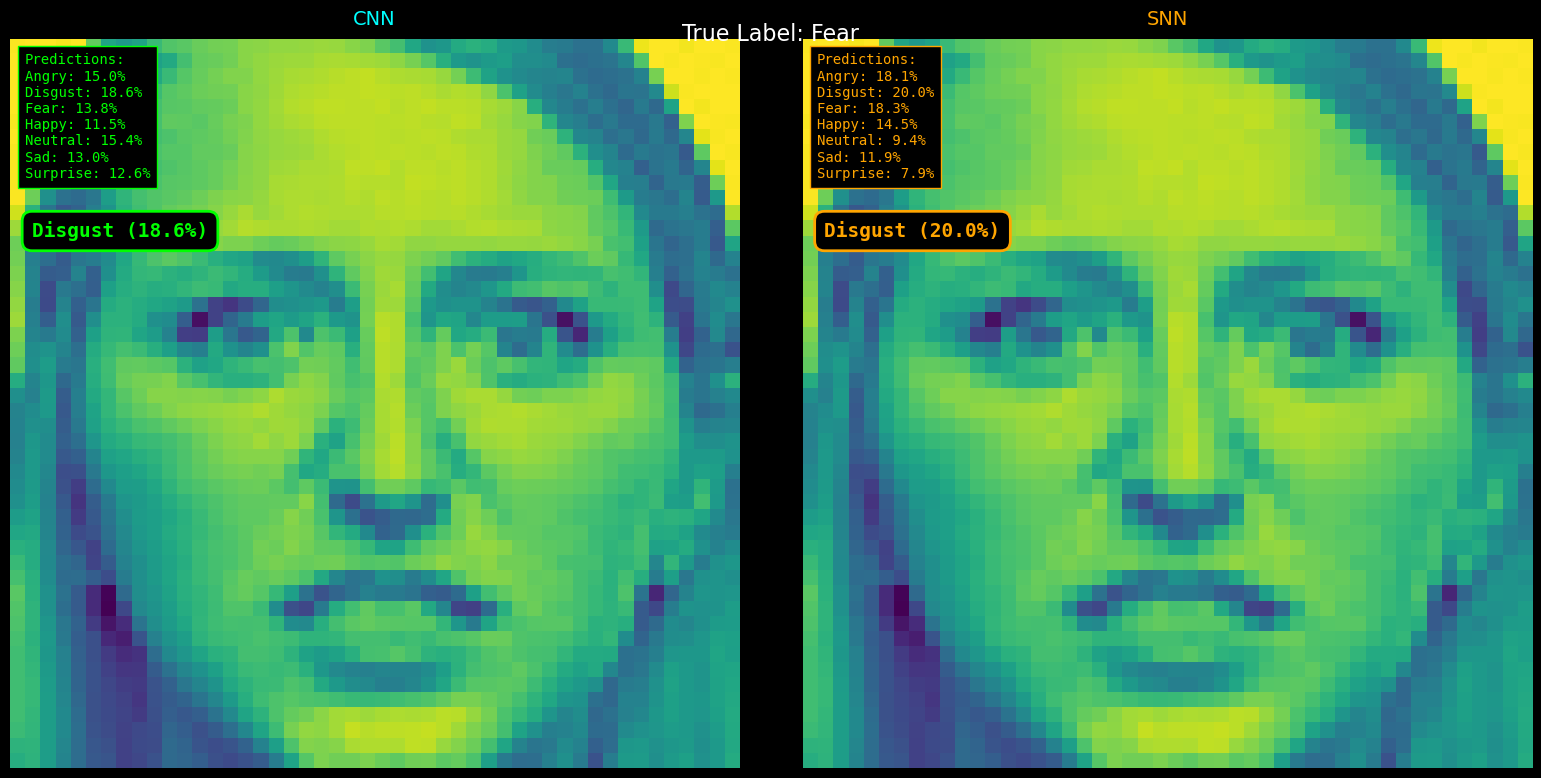

 Result saved: terminal_style_result.png
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/angry/PrivateTest_1809180.jpg
  True class detected: Angry
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Angry
   CNN: Fear (25.4%)
   SNN: Surprise (18.5%)
    Models disagree


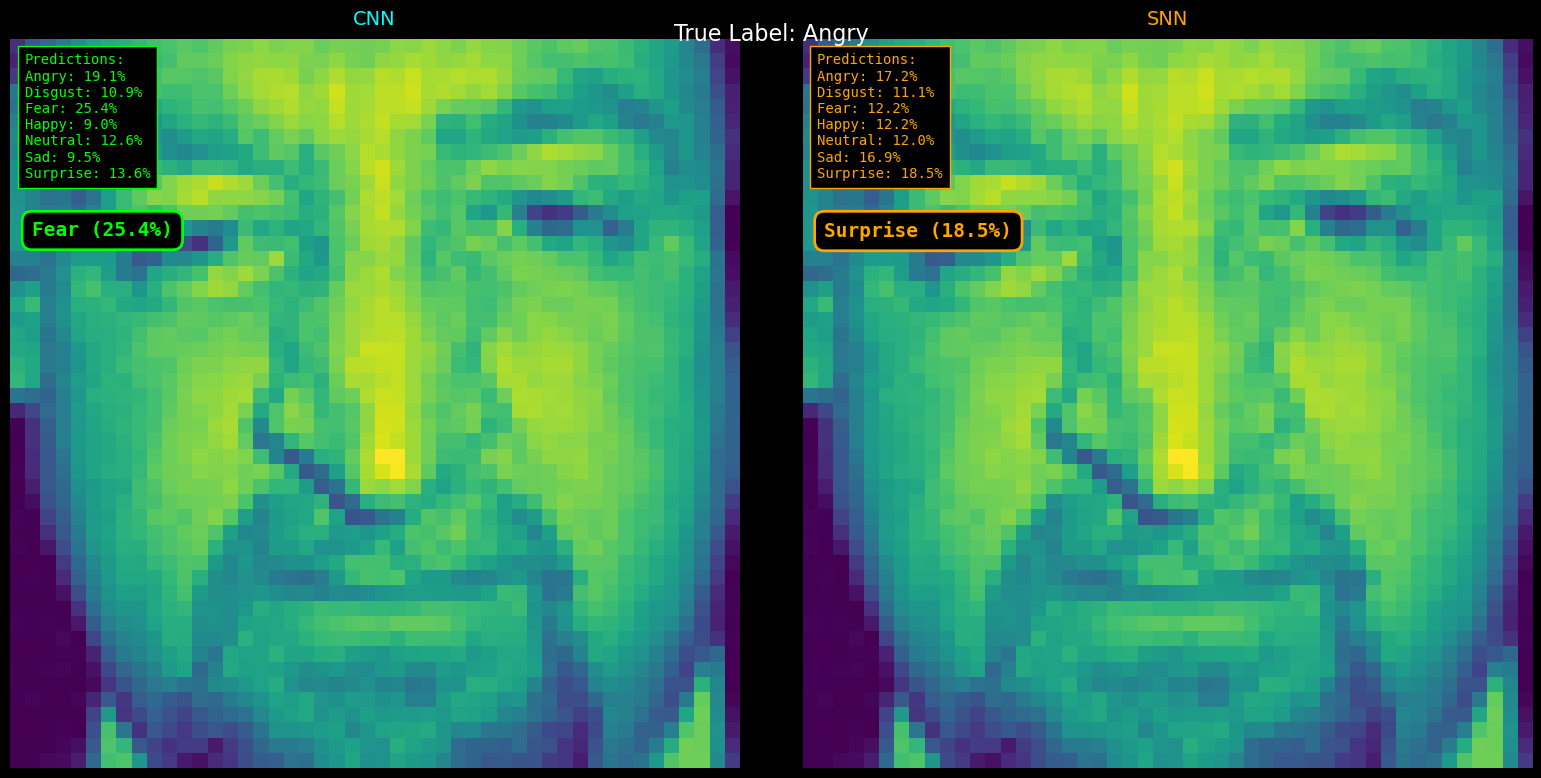

 Result saved: terminal_style_result.png
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/disgust/PrivateTest_4396496.jpg
  True class detected: Disgust
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Disgust
   CNN: Sad (22.8%)
   SNN: Happy (23.3%)
    Models disagree


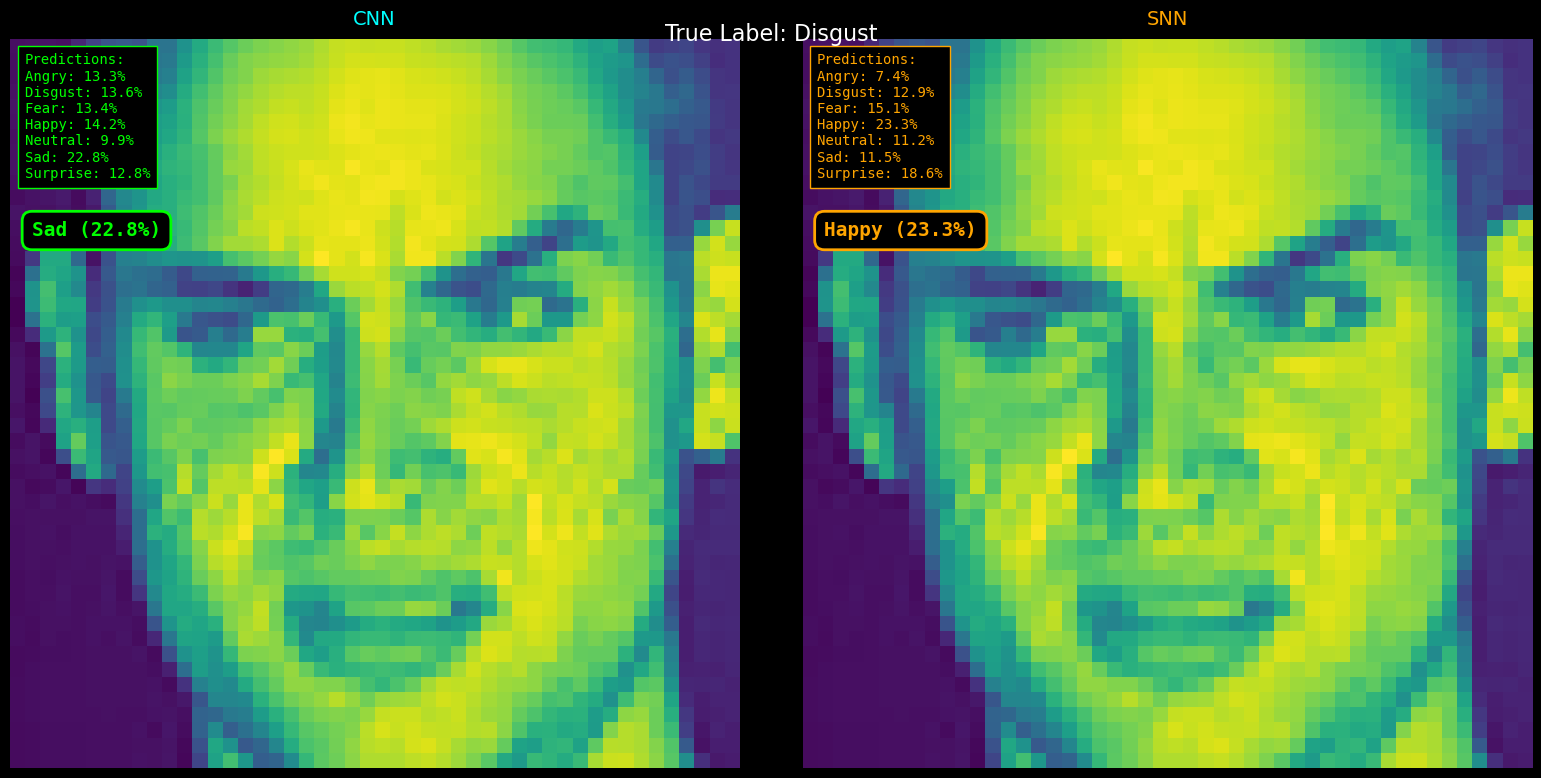

 Result saved: terminal_style_result.png
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/happy/PrivateTest_834081.jpg
  True class detected: Happy
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Happy
   CNN: Angry (18.1%)
   SNN: Fear (19.0%)
    Models disagree


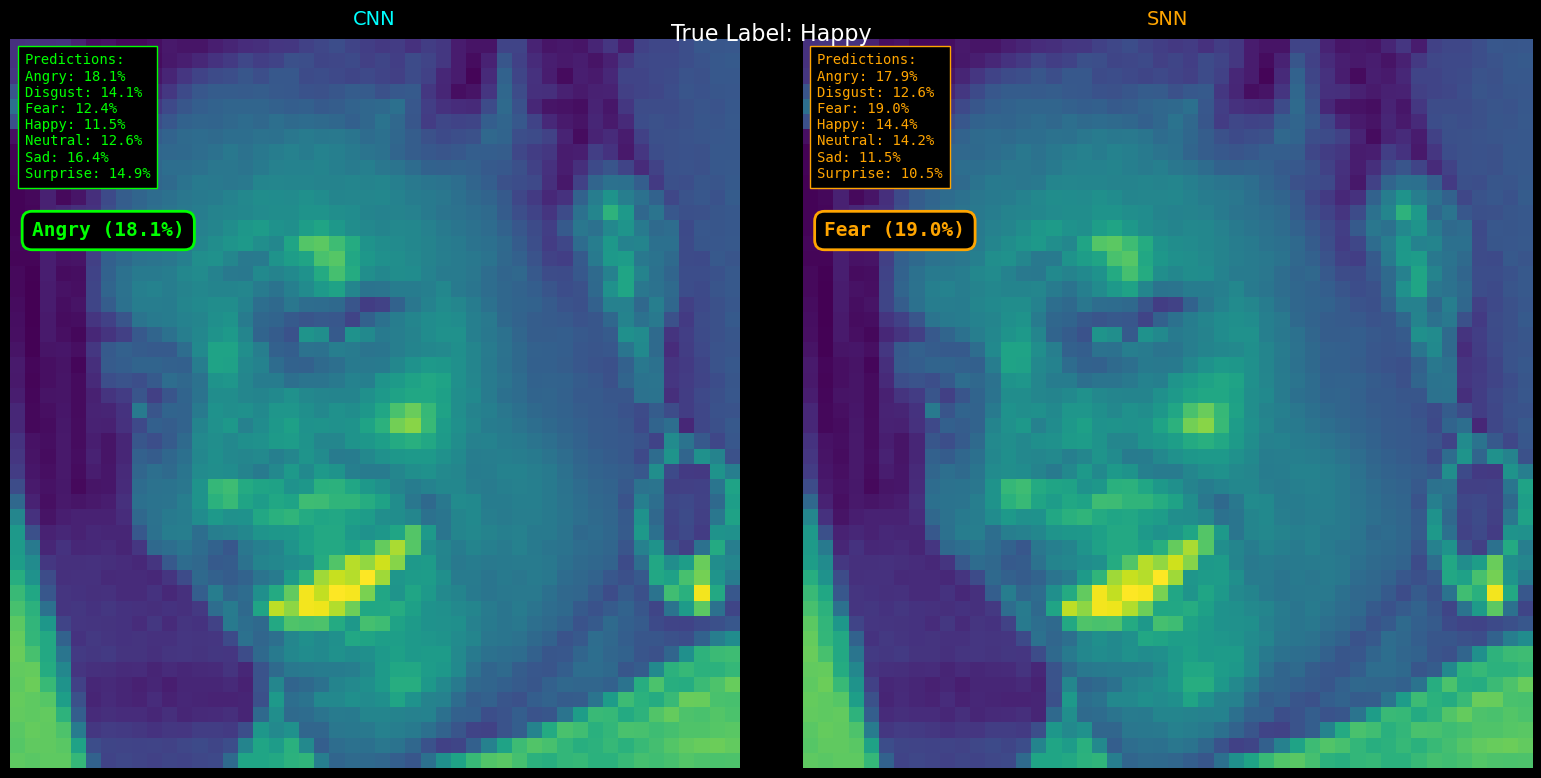

 Result saved: terminal_style_result.png
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/happy/PrivateTest_647018.jpg
  True class detected: Happy
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Happy
   CNN: Happy (27.7%)
   SNN: Angry (18.2%)
    Models disagree


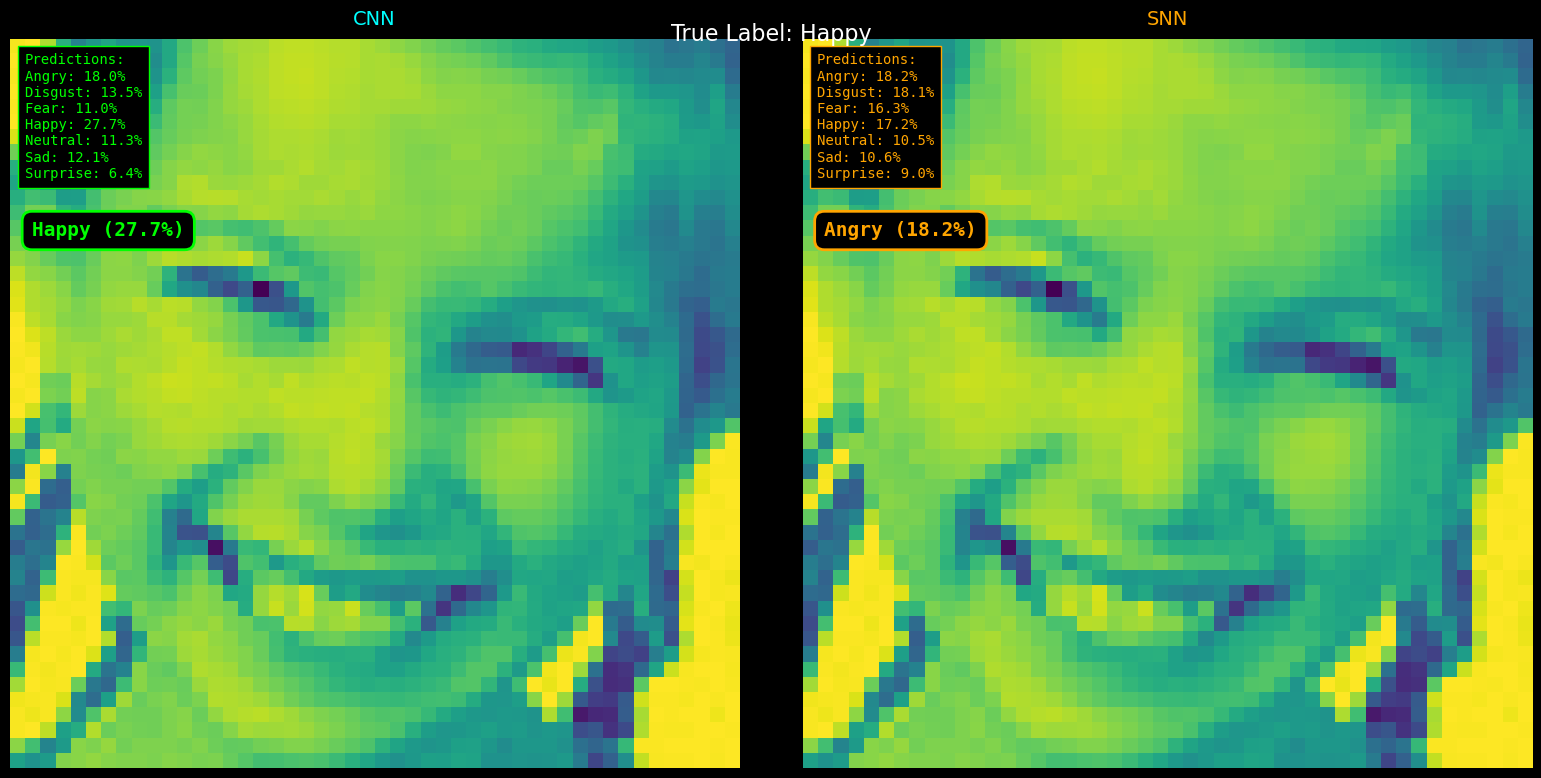

 Result saved: terminal_style_result.png
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/happy/PrivateTest_1533232.jpg
  True class detected: Happy
 Image loaded: torch.Size([1, 1, 48, 48])

 Creating models...
Création du modèle SEW-ResNet18...
Classes: 7
Pas temporels: 8
Encodage: temporal
Attempting SpikingJelly SEW-ResNet18...
SpikingJelly failed: 'NoneType' object is not callable
Using ResNet18 fallback...
ResNet18 fallback created
Paramètres totaux: 11,173,831
Paramètres entraînables: 11,173,831
Architecture: ResNet18 Fallback
⚡ Utilise fallback ResNet18
  Results directory not found - using random models

 Making predictions...

 RESULTS:
   True class: Happy
   CNN: Angry (16.1%)
   SNN: Surprise (26.5%)
    Models disagree


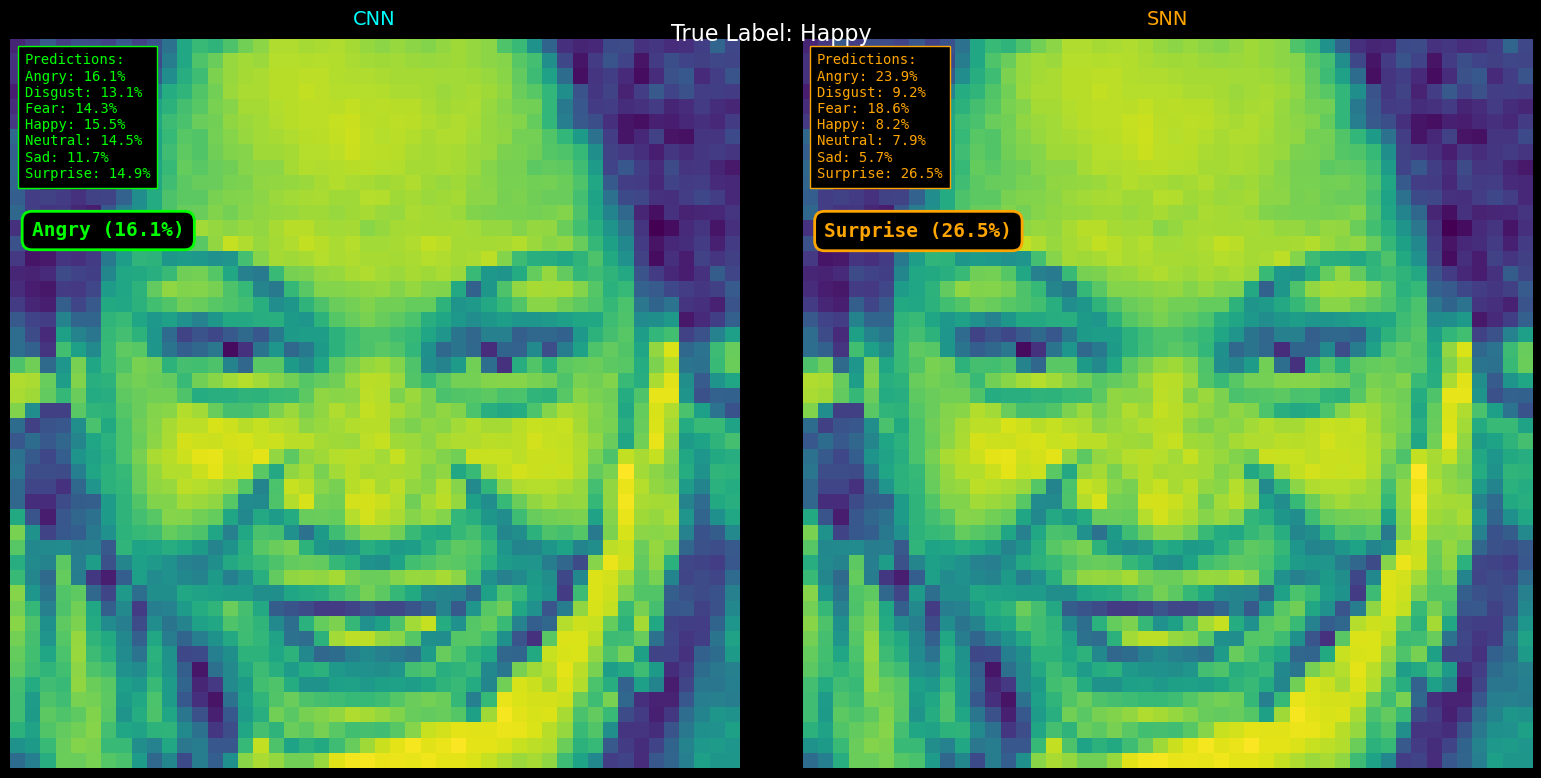

 Result saved: terminal_style_result.png
 Goodbye!


In [32]:

def load_and_test_single_image(image_path, models_dir="simple_snn_results"):
    """
    Tests a single image with CNN and SNN models in terminal style
    
    Args:
        image_path: Path to the image to test
        models_dir: Directory containing trained models
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    
    print(f" Device: {device}")
    print(f" Image: {image_path}")
    
    # Extract true class from path if possible
    true_class = None
    try:
        path_parts = Path(image_path).parts
        for part in path_parts:
            if part.capitalize() in class_names:
                true_class = part.capitalize()
                break
        if true_class:
            print(f"  True class detected: {true_class}")
    except:
        pass
    
    # Image transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load image
    try:
        image = Image.open(image_path)
        image_tensor = transform(image).unsqueeze(0).to(device)
        print(f" Image loaded: {image_tensor.shape}")
    except Exception as e:
        print(f" Image loading error: {e}")
        return
    
    # Create models
    print("\n Creating models...")
    ann_model = create_baseline_ann(num_classes=7)
    snn_model = create_sew_resnet18()
    
    ann_model = ann_model.to(device)
    snn_model = snn_model.to(device)
    
    # Find and load trained models
    results_dir = Path(models_dir)
    if results_dir.exists():
        experiment_dirs = [d for d in results_dir.iterdir() if d.is_dir()]
        if experiment_dirs:
            latest_dir = max(experiment_dirs, key=lambda x: x.stat().st_mtime)
            
            # Load CNN
            ann_path = latest_dir / "best_ann_model.pth"
            if ann_path.exists():
                checkpoint = torch.load(ann_path, map_location=device)
                ann_model.load_state_dict(checkpoint['model_state_dict'])
                print(f" CNN model loaded: {checkpoint.get('best_val_acc', 0):.3f}")
            else:
                print(" CNN model not found - using random model")
            
            # Load SNN
            snn_path = latest_dir / "best_snn_model.pth" 
            if snn_path.exists():
                checkpoint = torch.load(snn_path, map_location=device)
                snn_model.load_state_dict(checkpoint['model_state_dict'])
                print(f" SNN model loaded: {checkpoint.get('best_val_acc', 0):.3f}")
            else:
                print("  SNN model not found - using random model")
        else:
            print("  No experiment directory found - using random models")
    else:
        print("  Results directory not found - using random models")
    
    # Set to evaluation mode
    ann_model.eval()
    snn_model.eval()
    
    # Make predictions
    print("\n Making predictions...")
    with torch.no_grad():
        # CNN prediction
        ann_logits = ann_model(image_tensor)
        ann_probs = torch.softmax(ann_logits, dim=1)
        ann_pred = torch.argmax(ann_probs, dim=1).item()
        ann_confidence = torch.max(ann_probs, dim=1)[0].item()
        
        # SNN prediction
        reset_snn_state(snn_model)
        snn_logits = snn_model(image_tensor)
        snn_probs = torch.softmax(snn_logits, dim=1)
        snn_pred = torch.argmax(snn_probs, dim=1).item()
        snn_confidence = torch.max(snn_probs, dim=1)[0].item()
    
    # Display results
    print(f"\n RESULTS:")
    if true_class:
        print(f"   True class: {true_class}")
    print(f"   CNN: {class_names[ann_pred]} ({ann_confidence:.1%})")
    print(f"   SNN: {class_names[snn_pred]} ({snn_confidence:.1%})")
    
    if ann_pred == snn_pred:
        print(f"   Both models agree!")
    else:
        print(f"    Models disagree")
    
    # Create terminal-style visualization
    create_terminal_style_visualization(
        image, image_tensor, true_class,
        ann_pred, ann_confidence, ann_probs,
        snn_pred, snn_confidence, snn_probs,
        class_names
    )

def create_terminal_style_visualization(original_image, tensor_image, true_class,
                                      ann_pred, ann_conf, ann_probs,
                                      snn_pred, snn_conf, snn_probs, class_names):
    """Creates terminal-style visualization like your reference image"""
    
    # Prepare image for display
    img_display = tensor_image.squeeze().cpu().numpy()
    img_display = (img_display + 1) / 2  # Denormalize [-1,1] -> [0,1]
    
    # Create figure with black background
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor('black')
    
    # Main title with true class (if available)
    if true_class:
        fig.suptitle(f"True Label: {true_class}", fontsize=16, color='white', y=0.95)
    else:
        fig.suptitle("CNN vs SNN Comparison", fontsize=16, color='white', y=0.95)
    
    # Get probabilities as numpy arrays
    cnn_probs_np = ann_probs.squeeze().cpu().numpy()
    snn_probs_np = snn_probs.squeeze().cpu().numpy()
    
    # Left panel: CNN
    axes[0].imshow(img_display, cmap='viridis', aspect='equal')

    # Create terminal-style probability text for CNN
    prob_text = "Predictions:\n"
    for i, (name, prob) in enumerate(zip(class_names, cnn_probs_np)):
        prob_text += f"{name}: {prob*100:.1f}%\n"
    
    # Add text box at top with terminal style
    axes[0].text(0.02, 0.98, prob_text.strip(), 
                transform=axes[0].transAxes, fontsize=10,
                verticalalignment='top', color='lime',
                bbox=dict(boxstyle='square,pad=0.5', facecolor='black', 
                         edgecolor='lime', linewidth=1),
                fontfamily='monospace')
    
    # Add prediction box in center like your reference
    pred_text = f"{class_names[ann_pred]} ({ann_conf:.1%})"
    axes[0].text(0.03, 0.75, pred_text, 
                transform=axes[0].transAxes, fontsize=14,
                #horizontalalignment='center', 
                verticalalignment='top',# REMOVED: The problematic function replacement that was causing conflicts
# create_sew_resnet18 = create_working_sew_resnet18  # <-- This line caused the problem
                color='lime', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         edgecolor='lime', linewidth=2),
                fontfamily='monospace')
    
    axes[0].set_title("CNN", color='cyan', fontsize=14, pad=10)
    axes[0].axis('off')
    
    # Right panel: SNN
    axes[1].imshow(img_display, cmap='viridis', aspect='equal')

    # Create terminal-style probability text for SNN
    prob_text = "Predictions:\n"
    for i, (name, prob) in enumerate(zip(class_names, snn_probs_np)):
        prob_text += f"{name}: {prob*100:.1f}%\n"
    
    # Add text box at top with terminal style
    axes[1].text(0.02, 0.98, prob_text.strip(), 
                transform=axes[1].transAxes, fontsize=10,
                verticalalignment='top', color='orange',
                bbox=dict(boxstyle='square,pad=0.5', facecolor='black', 
                         edgecolor='orange', linewidth=1),
                fontfamily='monospace')
    
    # Add prediction box in center
    pred_text = f"{class_names[snn_pred]} ({snn_conf:.1%})"
    axes[1].text(0.03, 0.75, pred_text, 
                transform=axes[1].transAxes, fontsize=14,
                verticalalignment='top', 
                #horizontalalignment='center',
                color='orange', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         edgecolor='orange', linewidth=2),
                fontfamily='monospace')
    
    axes[1].set_title("SNN", color='orange', fontsize=14, pad=10)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig("terminal_style_result.png", dpi=300, bbox_inches='tight', 
                facecolor="blue", edgecolor='none')
    plt.show()
    
    print(f" Result saved: terminal_style_result.png")

def test_random_from_dataset(dataset_path="/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data"):
    """Tests a random image from the dataset"""
    
    test_dir = Path(dataset_path) / "test"
    if not test_dir.exists():
        print(f" Test directory not found: {test_dir}")
        return
    
    # Find all images
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_images = []
    
    for class_dir in test_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in image_extensions:
                    all_images.append(img_path)
    
    if not all_images:
        print(f" No images found in {test_dir}")
        return
    
    # Choose a random image
    random_image = np.random.choice(all_images)
    true_class = random_image.parent.name
    
    print(f" Random image selected:")
    print(f"   File: {random_image.name}")
    print(f"   True class: {true_class}")
    
    # Test the image
    load_and_test_single_image(str(random_image))

def interactive_menu():
    """Interactive menu to choose test type"""
    
    print("\n TERMINAL STYLE TEST MENU")
    print("=" * 35)
    print("1. Test a specific image")
    print("2. Test a random image from dataset")
    print("3. Exit")
    
    while True:
        try:
            choice = input("\nYour choice (1-3): ").strip()
            
            if choice == '1':
                img_path = input("Image path: ").strip()
                if os.path.exists(img_path):
                    load_and_test_single_image(img_path)
                else:
                    print(" File not found")
                    
            elif choice == '2':
                test_random_from_dataset()
                
            elif choice == '3':
                print(" Goodbye!")
                break
                
            else:
                print(" Invalid choice")
                
        except KeyboardInterrupt:
            print("\n Interrupted by user")
            break
        except Exception as e:
            print(f" Error: {e}")

if __name__ == "__main__":
    print(" TERMINAL STYLE CNN vs SNN TEST")
    print("=" * 40)
    
    # Check that modules are available
    try:
        # Quick import test
        test_tensor = torch.randn(1, 1, 48, 48)
        print(" PyTorch available")
        
        # Check CUDA
        if torch.cuda.is_available():
            print(f" CUDA available: {torch.cuda.get_device_name()}")
        else:
            print("  CUDA not available, using CPU")
            
        # Interactive menu
        interactive_menu()
        
    except Exception as e:
        print(f" Initialization error: {e}")
        import traceback
        traceback.print_exc()